# Tecnológico de Monterrey
## Maestría en Inteligencia Artificial Aplicada
---

### **Materia:** Proyecto Integrador

---

### **Avance 4:** Modelos alternativos

---

### **Proyecto:** Chatbot jurídico para soporte informativo en el análisis de carpetas de investigación

---

### **Profesora:** Dra. Grettel Barceló Alonso
### **Asesor:** Dr. Horacio Martínez Alfaro

---
### **Equipo 42 - Autorización individual**
### A00841954 Christian Erick Mercado Flores

---

Fecha: 19 de Octubre de 2025

### **Descripción del Proyecto**

En el marco del desarrollo de la materia de Proyecto Integrador, el presente trabajo propone el desarrollo del proyecto que lleva por título: **Chatbot jurídico para soporte informativo en el análisis de carpetas de investigación.**

La institución con la cual se colaborará y donde se implementará el proyecto es la **Fiscalía Especializada en Combate a la Corrupción del Estado de Michoacán**, también conocida como la **Fiscalía Anticorrupción de Michoacán**.

Específicamente, el área dentro de la institución donde se pondrá en marcha el trabajo es la **Unidad de Delitos Cometidos por Servidores Públicos y Particulares**.

### **Objetivo del Proyecto**

Poner a disposición de los agentes de la **Unidad de Delitos Cometidos por Servidores Públicos y Particulares** de la **Fiscalía Anticorrupción de Michoacán**, un **chatbot conversacional** que pueda proveer **soporte informativo** a partir del **marco jurídico aplicable** y de **carpetas de investigación** centralizados en un sistema de archivos.

### **Descripción del trabajo**

En este entregable se presenta la integración y configuración completa de un sistema ***RAG***, que incluye el **preprocesamiento de un corpus de texto**, la **generación de *embeddings*** del mismo, la incorporación de una **base de datos vectorial**, modelos ***Cross-Encoders*** y modelos ***LLM***, con el objetivo de procesar solicitudes y ofrecer respuestas lo más pertinentes posible, basadas en documentos de referencia.

Así pues, dentro de este trabajo se realiza un análisis de desempeño de diferentes modelos ***Cross-Encoder*** y ***LLM***, basados en diversas arquitecturas y con distintos parámetros de entrenamiento, con el fin de determinar, según métricas específicas, cuáles modelos podrían ser los mejores candidatos para integrarse en un sistema final de ***RAG***.

# Índice

#### 1. Librarías y Constantes

#### 2. Construcción de Corpus de Texto

#### 3. Preprocesamiento de Corpus de Texto

#### 4. Generación de *Embeddings*

#### 5. Modelos Alternativos
  * 5.1. Configuración
    * a) Base de Datos Vectorial
    * b) Modelos *Cross-Encoder*
    * c) Modelos *LLM*
    * d) Configuración Sistema *RAG*

  * 5.2. Comparativa de Desempeño
    * a) Evaluación de Recuperación
      * i. Evaluación de Recuperación de Base de Datos Vectorial
      * ii. Evaluación de Recuperación de los Modelos *Cross-Encoder*
    * b) Evaluación de Respuesta

  * 5.3. Ajuste Fino
    * a) Ajuste Fino de la Evaluación de Recuperación
      * i. Ajuste Fino de la Evaluación de Recuperación de Base de Datos Vectorial
      * ii. Ajuste Fino de la Evaluación de Recuperación de los Modelos *Cross-Encoder*
    * b) Ajuste Fino de la Evaluación de Respuesta

  * 5.4. Modelo Individual

#### 6. Conclusiones

#### 7. Referencias

# 1. Librarías y Constantes

In [1]:
pip install -q pandas numpy matplotlib seaborn tqdm tika pdfplumber python-docx pillow python-magic qdrant-client scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importación de Librearías

# 1) Librerías Estándar de Python
import gc
import math
import mimetypes
import os
import re
import subprocess
import time
from datetime import datetime
from pathlib import Path
from tabulate import tabulate

# 2) Librerías de Terceros
# 2.2) Librerías de ML/Data Science
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sentence_transformers import CrossEncoder
from sklearn.metrics import accuracy_score

# 2.2) Librerías de Visualización y Utilidades
import matplotlib.pyplot as plt
from tqdm import tqdm

# 2.3) Librerías para Procesamiento de Lenguaje Natural (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score

# 2.4) Librerías de Carga y Gestión de Archivos (I/O)
import magic
import pdfplumber
import requests
from docx import Document
from tika import parser as tika_parser

# 2.5) Librerías para Sistemas Vectoriales y Modelos
from qdrant_client import QdrantClient, models
from transformers import AutoModel, AutoTokenizer

In [3]:
# Configuración de Constantes
 
# 1) Definición de carpetas de textos
BASE_DIR = Path("./file-system")            # Ruta base del sistema de archivos
CARPETAS_DIR = BASE_DIR / "CARPETAS"        # Subcarpeta de carpetas de investigación
MARCO_LEGAL_DIR = BASE_DIR / "MARCO-LEGAL"  # Subcarpeta del marco legal

# 2) Configuración del dispositivo de cómputo
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Determina si se usará GPU (CUDA) o CPU

# 3) Carga y configuración del modelo de embeddings
EMBED_MODEL_NAME = 'nomic-ai/nomic-embed-text-v1.5'                 # Nombre del modelo de embeddings a usar
EMBED_TOKENIZER = AutoTokenizer.from_pretrained(EMBED_MODEL_NAME)   # Tokenizador asociado al modelo
EMBED_MODEL = AutoModel.from_pretrained(EMBED_MODEL_NAME, trust_remote_code=True).to(DEVICE).eval() # Carga del modelo en el dispositivo
MATRYOSHKA_DIM = 512 # Dimensión objetivo del espacio de embeddings Matryoshka

# 4) Configuración del endpoint local para Ollama
OLLAMA_BASE_URL = "http://localhost:11434"

<All keys matched successfully>


# 2. Construcción de Corpus de Texto

En esta sección se procedió a la **construcción de un corpus de textos** que representa los datos con lo cuales el proyecto "Chatbot jurídico para soporte informativo en el análisis de Carpetas de Investigación" va a trabajar. Este corpus está integrado por los siguientes tipos de documentos:
  - Documentos del **Marco Jurídico**: contienen textos que están divididos estructuralmente siguiendo una lógica jurídica como capítulos, secciones, artículos, entre otros (López Ruiz, 2002). Provienen de instituciones, entidades y fuentes legales (como Código Penal para el Estado de Michoacán, Ley Orgánica de la Fiscalía General del Estado de Michoacán, etc.).

  - Documentos de **Carpetas de Investigación**: tienen textos escritos siguiendo una narrativa legal o jurídica, o siguiendo formatos administrativo-legales. Se generan dentro de la propia Unidad de la Fiscalía con la que se trabaja en el proyecto.

In [4]:
def process_files(base_path):
    """
    Recorre recursivamente los archivos dentro de un directorio base y construye
    un DataFrame con metadatos de cada archivo encontrado.

    Parámetros:
        base_path (Path) : Objeto Path que indica el directorio base a recorrer.

    Retorno:
        pd.DataFrame : DataFrame que contiene una fila por archivo con las siguientes
                       columnas:
                       - "path"       (str)  : Ruta completa del archivo.
                       - "name"       (str)  : Nombre base del archivo sin extensión.
                       - "size_bytes" (int)  : Tamaño del archivo en bytes.
                       - "mime"       (str)  : Tipo MIME detectado o estimado del archivo.
    """

    # 1) Inicialización de estructura para almacenar resultados
    rows = []  # Lista donde se guardarán los metadatos de cada archivo

    # 2) Recorrido recursivo de todos los elementos en el directorio base
    for p in base_path.rglob("*"):  # Itera sobre todos los archivos y carpetas
        if p.is_file():             # Solo procesa si es archivo

            # 3) Obtención de metadatos básicos del archivo
            stat = p.stat() # Se obtiene información del sistema sobre el archivo
            mime = None     # Inicializa el valor MIME como None

            # 4) Intento de detección precisa del tipo MIME
            try:
                mime = magic.from_file(str(p), mime=True)  # Detecta MIME con librería 'magic'
            except Exception:
                mime = mimetypes.guess_type(p)[0]  # Estima MIME como fallback usando 'mimetypes'

            # 5) Almacenamiento de resultados en la lista de filas
            rows.append({
                "path": str(p),             # Ruta completa del archivo
                "name": p.stem,             # Nombre del archivo sin extensión
                "size_bytes": stat.st_size, # Tamaño en bytes
                "mime": mime,               # Tipo MIME detectado o estimado
            })

    # 6) Conversión de resultados a DataFrame
    return pd.DataFrame(rows)

In [5]:
# Procesamiento de archivos y muestra de estadísticas

# 1) Obtención de DataFrames con los archivos procesados
carpetas_df = process_files(CARPETAS_DIR)
marco_juridico_df = process_files(MARCO_LEGAL_DIR)

# 2) Impresión de resultados de conteo de archivos procesados
print(f"=== Archivos Procesados ==")
print(f"Archivos de Carpetas de Investigación: {len(carpetas_df)}")
print(f"Archivos de Marco Jurídico: {len(marco_juridico_df)}")

=== Archivos Procesados ==
Archivos de Carpetas de Investigación: 53
Archivos de Marco Jurídico: 24


In [6]:
# Vista previa de los primeros registros
carpetas_df.head()

,path,name,size_bytes,mime
0,file-system/CARPETAS/2025-MICH-FECC-0002456/2-...,acuerdo_de inicio_de_carpeta_de_investigacion,125848,application/pdf
1,file-system/CARPETAS/2025-MICH-FECC-0002456/2-...,acta_de_lectura_de_derechos,121285,application/pdf
2,file-system/CARPETAS/2025-MICH-FECC-0002456/2-...,constancia_de_asignacion_de_numero_de_carpeta,105890,application/pdf
3,file-system/CARPETAS/2025-MICH-FECC-0002456/1-...,lista_de_anexos,140763,application/pdf
4,file-system/CARPETAS/2025-MICH-FECC-0002456/1-...,acta_de_recepcion,111097,application/pdf


In [7]:
# Información general del DataFrame
carpetas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        53 non-null     object
 1   name        53 non-null     object
 2   size_bytes  53 non-null     int64 
 3   mime        53 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.8+ KB


In [8]:
# Vista previa de los primeros registros
marco_juridico_df.head()

,path,name,size_bytes,mime
0,file-system/MARCO-LEGAL/TIPO-DELITO/codigo_pen...,codigo_penal_para_el_estado_de_michoacan,1940655,application/pdf
1,file-system/MARCO-LEGAL/TIPO-DELITO/ley_organi...,ley_organica_de_la_fiscalia_general_del_estado...,616234,application/pdf
2,file-system/MARCO-LEGAL/TIPO-DELITO/reglamento...,reglamento_de_la_ley_organica_de_la_fiscalia_g...,1382808,application/pdf
3,file-system/MARCO-LEGAL/PROCESO-PENAL/corte_in...,corte_interamericana_de_derechos_humanos_caso_...,711015,application/pdf
4,file-system/MARCO-LEGAL/PROCESO-PENAL/jurispru...,jurisprudencia_responsabilidades_administrativas,10130803,application/pdf


In [9]:
# Información general del DataFrame
marco_juridico_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        24 non-null     object
 1   name        24 non-null     object
 2   size_bytes  24 non-null     int64 
 3   mime        24 non-null     object
dtypes: int64(1), object(3)
memory usage: 900.0+ bytes


In [10]:
def separate_files_by_case(df):
    """
    Separa un DataFrame en múltiples subconjuntos según el nombre del caso
    (extraído del path del archivo). Cada subconjunto se almacena en un
    diccionario, donde la clave es el nombre del caso y el valor es el
    DataFrame correspondiente.

    Parámetros:
        df (pd.DataFrame) : DataFrame que contiene al menos una columna 'path'
                            con rutas de archivos (por ejemplo: /data/case1/file.pdf).

    Retorno:
        dict : Diccionario donde:
               - "clave" (string)       : Nombre del caso
               - "valor" (pd.DataFrame) : DataFrame con los registros pertenecientes a ese caso
    """

    # 1) Crear una nueva columna 'case' extrayendo el nombre de la carpeta de investigación del path
    #    Se asume que el nombre de la carpeta de investigación está en la tercera posición del path (índice 2)
    df['case'] = df['path'].apply(lambda x: x.split('/')[2])

    # 2) Inicializar un diccionario para guardar los DataFrames por carpeta de investigación
    dfs_by_folder = {}

    # 3) Agrupar el DataFrame principal por el nombre de la carpeta de investigación
    groups = df.groupby('case')

    # 4) Iterar sobre cada grupo (cada carpeta de investigación)
    for folder_name, df_group in groups:
        # Crear una copia del DataFrame del grupo sin la columna auxiliar 'case'
        df_final = df_group.drop(columns=['case']).copy()

        # Guardar el DataFrame en el diccionario con la clave del nombre de la carpeta de investigación
        dfs_by_folder[folder_name] = df_final

    # 5) Devolver el diccionario de DataFrames
    return dfs_by_folder

In [11]:
# Separación de los archivos en diferentes DataFrames según el caso identificado en el path

# 1) Llamada a la función que organiza los archivos por carpeta de investigación
carpetas_dfs = separate_files_by_case(carpetas_df)

# 2) Visualización de los nombres de las carpetas de investigación obtenidas
print("=== Diferentes Carpetas de Investigación (Folios) ===")
print(carpetas_dfs.keys())

=== Diferentes Carpetas de Investigación (Folios) ===
dict_keys(['2025-MICH-FECC-0001789', '2025-MICH-FECC-0002456'])


# 3. Preprocesamiento de Corpus de Texto

En esta sección se procedió con el **preprocesamiento del corpus de texto**. Este proceso es sustancialmente diferente al preprocesamiento de los tipos de datos numéricos o categóricos. Pues, el procesar los textos no se trata de una tarea de buscar valores atípicos, faltantes o imputar cifras, sino que la tarea en realidad es preservar tanto la estructura lógica e integridad semántica de los textos (Ferraris et al., 2024), toda vez que son procesados para que los modelos de *Machine Learning* puedan utilizarlos. Para esta tarea de preprocesamiento se utilizaron técnicas de Procesamiento de Lenguaje Natural o *Natural Language Processing* (*NLP*). Específicamente, se aplicaron técnicas de limpieza, *tokenización* (dividir el texto en unidades más pequeñas como palabras, subpalabras o caracteres), *overlapping* (solapamiento parcial entre fragmentos consecutivos para mantener contexto) y *chunking* (dividir fragmentos de texto o *tokens* en segmentos) (Vaj, 2024).

Los procesos que se implementaron fueron los siguientes:

* ***Limpieza de Texto***: tanto los documentos del **Marco Jurídico** como los de las **Carpetas de Investigación** representan textos que siguen una lógica narrativa y descriptiva propia del campo legal. Aunque los documentos del **Marco Jurídico** presentan estructuras más rígidas (como artículos) y los de las **Carpetas de Investigación** tienen una narrativa más administrativa y legal, en ambos casos, la puntuación, los saltos de línea y la estructura son importantes para mantener el contexto semántico de los textos. En este sentido, se procedió con una limpieza de texto más simple para que el contenido no se perdiera, aplicando normalización de saltos de línea, espacios, comillas, secuencias repetidas, así como eliminación de caracteres invisibles.

* ***Tokenización, Overlapping y Chunking***: para cada tipo de documento se siguió una estrategia de división de *chunks* distinta o *chunking*, derivado de la naturaleza de los mismos documentos. Sin embargo, el proceso de *overlapping* y *tokenización* fue el mismo para todos los documentos. Para el proceso de *tokenización*, se codificaron los caracteres con base en el tokenizador del modelo de *embeddings* `nomic-ai/nomic-embed-text-v1.5` utilizado por este proyecto, con el objetivo de calcular posiciones de *tokens* precisas y coherentes con dicho modelo. Por otro lado, al realizar el *overlapping* entre *tokens* de los *chunks* para preservar el contexto, se siguió la misma técnica que fue basada en el método descrito en el artículo "*No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts*" (Fama et al., 2024). El proceso de *overlapping* aplicado inició con el cálculo de un porcentaje de *tokens* al inicio y final de cada *chunk*. Ese porcentaje estuvo representado por la métrica `Z`, para hacer un *overlapping* con los vecinos adyacentes, creando así una superposición simétrica de `Z/2` *tokens* en los límites de cada *chunk* adyacente para preservar el contexto. Las dimensiones de los *chunks* fueron determinadas de la siguiente manera para cada documento:

  * Documentos de **Carpetas de Investigación**: estos archivos no presentan una estructura extensa ni rígida como la de los artículos legales. Por ello, se estableció un tamaño estándar de 512 *tokens* por *chunk*, con el objetivo de granular el contexto sin fragmentarlo excesivamente. Los cortes se realizan de manera continua, sin identificar estructuras específicas, aplicando un *overlapping* del 5% para mantener coherencia entre fragmentos.

  * Documentos del **Marco Jurídico**: estos documentos presentan estructuras más rígidas. Por ello, los *chunks* se generaron basándose en la identificación de estas estructuras mediante expresiones regulares. Primero, se detectaron secciones que suelen agrupar mayor cantidad de texto, como libros, capítulos y secciones. Luego, dentro de cada contexto, se identificaron estructuras más granulares, como los artículos, de modo que cada *chunk* representó un artículo específico dentro de su contexto. Para textos legales que no presentaron estas estructuras clásicas, se aplicó un enfoque similar al utilizado para las **Carpetas de Investigación**, generando *chunks* de manera continua. En todos los casos, se estableció un tamaño estándar de 512 *tokens* por *chunk* y un *overlapping* del 5%, con el objetivo de granular el contexto sin fragmentarlo excesivamente y mantener coherencia entre fragmentos.

In [12]:
def extract_text_pdf(path):
    """
    Extrae el contenido textual de un archivo PDF.

    Parámetros:
        path (str) : Ruta al archivo PDF a procesar.

    Retorno:
        str : Texto completo extraído del PDF. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Inicialización de lista para almacenar texto de cada página
        texts = []

        # 3) Apertura del PDF y extracción de texto por página
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                texts.append(page.extract_text() or "") # Extrae texto o agrega cadena vacía

        # 4) Unión de todos los textos en un solo string
        return "\n".join(texts)

    # 5) Retorno en caso de error durante la extracción
    except Exception as e:
        return ""

In [13]:
def extract_text_docx(path):
    """
    Extrae el contenido textual de un archivo DOCX.

    Parámetros:
        path (str) : Ruta al archivo DOCX a procesar.

    Retorno:
        str : Texto completo extraído del DOCX. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Apertura del documento DOCX
        doc = Document(path)

        # 3) Extracción del texto de cada párrafo
        parts = [p.text for p in doc.paragraphs]

        # 4) Unión de todos los textos en un solo string
        return "\n".join(parts)

    # 5) Retorno en caso de error durante la extracción
    except Exception:
        return ""

In [14]:
def extract_text_tika(path):
    """
    Extrae el contenido textual de un archivo usando Apache Tika.

    Parámetros:
        path : Ruta al archivo a procesar con Tika.

    Retorno:
        str : Texto completo extraído del archivo. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Parseo del archivo usando Tika
        parsed = tika_parser.from_file(path)
        content = parsed.get('content') or parsed.get('text') or "" # Obtiene contenido principal

        # 3) Decodificación si el contenido está en bytes
        if isinstance(content, bytes):
            try:
                content = content.decode('utf-8', errors='ignore')
            except Exception:
                content = str(content)  # Fallback a string estándar si falla decodificación

        # 4) Retorno del contenido extraído
        return content or ""

    # 5) Retorno en caso de error durante la extracción
    except Exception:
        return ""

In [15]:
def extract_text(path):
    """
    Extrae el texto de un archivo aplicando primero métodos específicos por tipo
    de archivo y, si fallan, utiliza Tika como fallback.

    Parámetros:
        path (str) : Ruta al archivo a procesar.

    Retorno:
        str : Texto completo extraído del archivo, limpio de espacios iniciales y finales.
    """

    # 1) Determinar la extensión del archivo
    ext = Path(path).suffix.lower()
    text = ""

    # 2) Procesamiento de PDFs
    if ext == '.pdf':
        text = extract_text_pdf(path)       # Intento preferido con pdfplumber
        if not text:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 3) Procesamiento de archivos Word
    elif ext in ['.docx', '.doc']:
        text = extract_text_docx(path)      # Intento preferido con python-docx
        if not text:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 4) Procesamiento de archivos de texto plano o Markdown
    elif ext in ['.txt', '.md']:
        try:
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()             # Lectura directa de archivo
        except Exception:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 5) Otros tipos de archivo
    else:
        text = extract_text_tika(path)      # Uso directo de Tika

    # 6) Retorno del texto limpio
    return (text or "").strip()

In [16]:
def process_text(text):
    """
    Realiza una limpieza y normalización avanzada del texto, eliminando caracteres invisibles,
    espacios redundantes, saltos de línea inconsistentes y comillas tipográficas. 
    Su objetivo es dejar el texto en un formato uniforme y listo para procesamiento posterior.

    Parámetros:
        text (str) : Texto de entrada a limpiar y normalizar.

    Retorno:
        str : Texto limpio, normalizado y sin caracteres problemáticos o redundantes.
    """

    # 1) Verificación de texto válido
    if not text:
        return ""

    # 2) Normalización de saltos de línea y espacios
    text = text.replace("\r\n", "\n").replace("\r", "\n")   # Unifica los saltos de línea al formato estándar '\n'
    text = re.sub(r'\n+', '\n', text)                       # Reduce múltiples saltos de línea consecutivos a uno solo
    text = re.sub(r'[ \t]+', ' ', text)                     # Sustituye múltiples espacios o tabulaciones por un solo espacio
    text = re.sub(r' +\n', '\n', text)                      # Elimina espacios antes de los saltos de línea

    # 3) Limpieza de caracteres invisibles
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)

    # 4) Sustitución de comillas tipográficas por comillas estándar
    text = text.replace("“", '"').replace("”", '"') # Reemplaza comillas dobles curvas por comillas rectas
    text = text.replace("‘", "'").replace("’", "'") # Reemplaza comillas simples curvas por comillas rectas

    # 5) Eliminación de espacios redundantes
    text = re.sub(r'\s+', ' ', text)

    # 6) Normalización de caracteres repetidos
    text = re.sub(r'([._\-=:;])\1+', r'\1', text)

    # 7) Limpieza final de bordes
    text = text.strip()

    # 8) Retorno del texto limpio
    return text

In [17]:
def generate_chunks(text, tokenizer, chunk_size=512, overlap_percent=0.05):
    """
    Divide un texto largo en fragmentos (chunks) basados en el número de tokens, 
    manteniendo un pequeño solapamiento entre ellos para preservar la coherencia del contexto.

    Parámetros:
        text (str)                          : Texto de entrada que se desea dividir en fragmentos.
        tokenizer (PreTrainedTokenizer)     : Tokenizador del modelo que se usará para codificar y decodificar el texto.
        chunk_size (int, opcional)          : Cantidad máxima de tokens por fragmento. Por defecto es 512.
        overlap_percent (float, opcional)   : Porcentaje de solapamiento entre fragmentos consecutivos. Por defecto es 0.05 (5%).

    Retorno:
        list[str] : Lista de fragmentos de texto (chunks) generados a partir del texto original, 
                    con cortes seguros y coherentes dentro de oraciones o párrafos.
    """

    # 1) Tokenización del texto
    tokens = tokenizer.encode(text, add_special_tokens=False)
    
    if not tokens:
        return []

    # 2) Inicialización de variables de control
    chunks = []                             # Lista para almacenar los fragmentos resultantes
    total_tokens = len(tokens)              # Total de tokens en el texto original
    z = int(chunk_size * overlap_percent)   # Número de tokens que se solaparán entre fragmentos
    z_half = z // 2                         # Mitad del solapamiento para avanzar parcialmente en cada iteración
    start_token = 0                         # Índice inicial del primer fragmento

    # 3) Bucle principal de generación de fragmentos
    while start_token < total_tokens:  
        end_token = min(start_token + chunk_size, total_tokens) # Define el límite superior del fragmento actual
        chunk_text = tokenizer.decode(tokens[start_token:end_token], skip_special_tokens=True)  # Decodifica los tokens seleccionados

        # 4) Ajuste de corte seguro dentro del texto decodificado
        slice_ = chunk_text  # Copia del texto actual para búsqueda de delimitadores
        idx = max(slice_.rfind(". "), slice_.rfind("? "), slice_.rfind("! "), slice_.rfind("\n\n"))  # Busca el último signo
        
        if idx > int(len(slice_) * 0.3):            # Solo realiza el corte si el punto está después del 30% del texto
            chunk_text = slice_[:idx + 1].strip()   # Corta el texto hasta el delimitador y elimina espacios

        # 5) Almacenamiento del fragmento y avance del índice
        chunks.append(chunk_text)           # Agrega el fragmento procesado a la lista de resultados
        start_token += chunk_size - z_half  # Avanza el índice inicial para el siguiente fragmento, aplicando el solapamiento

    # 6) Retorno final
    return chunks

In [18]:
def split_articles_within_context(text, tokenizer, chunk_size, overlap_percent, context=None):
    """
    Divide un texto extenso en fragmentos (chunks) por artículos legales o secciones numeradas,
    conservando un contexto opcional (por ejemplo, encabezados o secciones previas).
    Luego genera subfragmentos por tokens para cada artículo, manteniendo coherencia semántica.

    Parámetros:
        text (str)                      : Texto completo que se desea dividir en artículos o secciones.
        tokenizer (PreTrainedTokenizer) : Tokenizador que se usará para segmentar los textos por tokens.
        chunk_size (int)                : Cantidad máxima de tokens permitidos por fragmento.
        overlap_percent (float)         : Porcentaje de solapamiento entre fragmentos consecutivos.
        context (list[str], opcional)   : Lista de cadenas que representan un contexto adicional 
                                          (por ejemplo, encabezados o títulos previos) que se añadirá
                                           antes de cada artículo. Por defecto es None.

    Retorno:
        list[str] : Lista de fragmentos de texto resultantes, generados a partir de los artículos
                    y el contexto provisto, con divisiones seguras por tokens.
    """

    # 1) Verificación de texto válido
    if not text.strip():
        return []

    # 2) Construcción del contexto inicial
    context_text = "\n".join(context) + "\n" if context else ""

    # 3) División del texto en artículos individuales
    article_pattern = re.compile(  # Expresión regular para detectar encabezados tipo "Artículo X" o "Art. X"
        r'(?im)(?=^Art[íi]?culo\.?\s*\d+[A-Za-z\-]*|^Art\.\s*\d+[A-Za-z\-]*)'
    )
    articles = re.split(article_pattern, text)              # Separa el texto en función de los encabezados detectados
    articles = [a.strip() for a in articles if a.strip()]   # Limpia espacios y elimina elementos vacíos

    # 4) Generación de fragmentos (chunks) por artículo
    chunks = [] # Lista para almacenar todos los fragmentos generados
    for art in articles:  
        article_full = context_text + art   # Combina el contexto con el contenido del artículo
        subchunks = generate_chunks(        # Llama a la función de división por tokens para cada artículo
            article_full,
            tokenizer,
            chunk_size=chunk_size,
            overlap_percent=overlap_percent
        )
        chunks.extend(subchunks)    # Agrega los fragmentos resultantes a la lista principal

    # 5) Retorno final
    return chunks

In [19]:
def generate_chunks_legal_structures(text, tokenizer, chunk_size=512, overlap_percent=0.05):
    """
    Segmenta un texto jurídico extenso en fragmentos (chunks) estructurados según niveles jerárquicos 
    comunes en documentos legales (Libro, Título, Capítulo, Sección, Artículo).
    Conserva el contexto jerárquico de encabezados para cada grupo de artículos y genera 
    fragmentos por tokens de tamaño controlado.

    Parámetros:
        text (str)                          : Texto legal completo que se desea dividir en fragmentos estructurados.
        tokenizer (PreTrainedTokenizer)     : Tokenizador del modelo utilizado para dividir el texto por tokens.
        chunk_size (int, opcional)          : Cantidad máxima de tokens permitidos por fragmento. Por defecto es 512.
        overlap_percent (float, opcional)   : Porcentaje de solapamiento entre fragmentos consecutivos. Por defecto es 0.05 (5%).

    Retorno:
        list[str] : Lista de fragmentos de texto generados a partir de la estructura jerárquica legal,
                    con preservación del contexto de encabezados (Libro, Título, Capítulo, etc.).
    """

    # 1) Verificación de texto válido
    if not text:
        return []

    # 2) Inserción de saltos de línea antes de estructuras legales principales
    text = re.sub(  # Agrega saltos antes de encabezados estructurales como "LIBRO", "TÍTULO", "CAPÍTULO", etc.
        r'(?i)(?=\b(LIBRO\s+\w+|T[IÍ]TULO\s+\w+|CAP[IÍ]TULO\s+\w+|SECCI[ÓO]N\s+\w+|ART[IÍ]CULO\s+\w+|ART\.\s*\w+))',
        r'\n',
        text
    )

    # 3) Definición del patrón de encabezados jerárquicos
    header_pattern = re.compile(  # Detecta líneas que representan encabezados de secciones legales
        r'(?im)^(LIBRO\s+[\w\d]+.*|T[IÍ]TULO\s+[\w\d]+.*|CAP[IÍ]TULO\s+[\w\d]+.*|SECCI[ÓO]N\s+[\w\d]+.*)$'
    )

    # 4) Inicialización de estructuras de control
    chunks = []             # Lista para almacenar los fragmentos resultantes
    current_context = []    # Lista que guarda el contexto jerárquico actual (por ejemplo, Libro, Título, etc.)
    current_text = ""       # Texto acumulado del bloque actual

    # 5) División del texto en líneas
    lines = text.split("\n") # Separa el texto por líneas para identificar encabezados y contenido

    # 6) Recorrido de las líneas para segmentación jerárquica
    for line in lines:
        line_stripped = line.strip()    # Elimina espacios en blanco al inicio y final de la línea
        if not line_stripped:           # Ignora líneas vacías
            continue

        if header_pattern.match(line_stripped):     # Si la línea es un encabezado jerárquico
            if current_text.strip():                # Si ya se acumuló texto antes del encabezado actual
                chunks.extend(                      # Divide el texto anterior en artículos y genera sus chunks
                    split_articles_within_context(
                        current_text, tokenizer, chunk_size, overlap_percent
                    )
                )
                current_text = ""                   # Reinicia el texto acumulado
            current_context.append(line_stripped)   # Añade el encabezado al contexto jerárquico
            continue                                # Pasa a la siguiente línea

        current_text += line + "\n" # Acumula el contenido que pertenece al contexto actual

    # 7) Procesamiento final del texto restante
    if current_text.strip(): # Si queda texto sin procesar al final del documento
        chunks.extend(
            split_articles_within_context(
                current_text, tokenizer, chunk_size, overlap_percent, context=current_context
            )
        )

    # 8) Retorno final
    return chunks

In [20]:
def process_text_and_generate_chunks(files_df, tokenizer=EMBED_TOKENIZER, are_legal_structures=False):
    """
    Procesa archivos para extraer y segmentar el texto en chunks listos para vectorización.

    Parámetros:
        files_df (pd.DataFrame)     : DataFrame con al menos las columnas 'path' y 'name'.
        are_legal_structures (bool) : Si True, usa chunking basado en estructura legal.

    Retorno:
        pd.DataFrame : DataFrame con los chunks generados. Cada fila contiene el nombre del documento,
                       un identificador de chunk, el texto correspondiente y metadata de tokens y chunks.
    """

    # 1) Inicialización de lista donde se almacenarán los chunks generados
    chunks_list = []

    # 2) Iteración sobre cada archivo en el DataFrame para procesar su texto
    for idx, row in tqdm(files_df.iterrows(), total=len(files_df)): # Se usa tqdm para mostrar el progreso del bucle
        path = row['path']
        doc = row['name']
        text = extract_text(path)                                   # Extrae el texto del archivo
        clean_text = process_text(text)                             # Limpieza de texto

        # 3) Procesamiento del texto según el tipo de estructura (legal o de expediente)
        if are_legal_structures:                                    # Si se indica que el documento tiene estructura legal
            chunks = generate_chunks_legal_structures(clean_text, tokenizer)
        else:                                                       # Si no es un documento legal, aplica un procesamiento estándar
            chunks = generate_chunks(clean_text, tokenizer)

        # 4) Construcción de la lista de chunks con su respectiva metadata
        for i, chunk in enumerate(chunks):
            chunks_list.append({
                'doc': doc,
                'text': chunk,
                'chunk_size': len(tokenizer.encode(chunk, add_special_tokens=False)),
            })

    # 5) Retorno del resultado como DataFrame para facilitar su análisis y vectorización
    return pd.DataFrame(chunks_list)

In [21]:
def plot_chunks(df, title, column='chunk_size'):
    """
    Genera un histograma que muestra la distribución del tamaño de los chunks
    (fragmentos de texto) dentro de un DataFrame, añadiendo una línea vertical
    que indica la media del tamaño de los chunks.

    Parámetros:
        df (pd.DataFrame) : DataFrame que contiene los datos de chunks.
        title (str)       : Título descriptivo para el gráfico.
        column (str)      : Nombre de la columna que contiene los tamaños de los chunks.
                            Por defecto es 'chunk_size'.

    Retorno:
        None : La función no retorna ningún valor, solo muestra el gráfico.
    """

    # 1) Validación de existencia de la columna a graficar
    if column not in df.columns:
        raise ValueError(f"La columna '{column}' no existe en el DataFrame.") # Validación temprana de integridad

    # 2) Cálculo del valor medio de la columna seleccionada
    mean_value = df[column].mean() # Obtiene la media del tamaño de los chunks

    # 3) Configuración del estilo visual de Seaborn
    sns.set(style="whitegrid") # Define un estilo limpio con fondo cuadriculado

    # 4) Creación del gráfico de histograma
    plt.figure(figsize=(8, 5))                                    # Define el tamaño de la figura
    sns.histplot(df[column], bins=30, kde=True, color='skyblue')  # Dibuja el histograma con densidad KDE

    # 5) Adición de línea vertical indicando la media
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f"Media = {mean_value:.1f}") # Línea de media

    # 6) Configuración de títulos, etiquetas y leyenda
    plt.title(f"Distribución de {column} para {title}", fontsize=13, weight='bold')
    plt.xlabel("Tamaño de Chunk en número de Tokens")
    plt.ylabel("Frecuencia")

In [22]:
# Procesamiento de metadatos de archivos de carpetas y vista previa

# 1) Generación de DataFrame chunks
carpetas_chunks_dfs = {
    key: process_text_and_generate_chunks(value)
    for key, value in carpetas_dfs.items()
}

# 2) Información general del DataFrame
for key, df in carpetas_chunks_dfs.items():
    print(f"\n=== Información de la Carpeta de Investigación: {key} ===\n")
    display(df.info())

100%|██████████| 23/23 [00:04<00:00,  4.79it/s]


=== Información de la Carpeta de Investigación: 2025-MICH-FECC-0001789 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc         156 non-null    object
 1   text        156 non-null    object
 2   chunk_size  156 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.8+ KB


None


=== Información de la Carpeta de Investigación: 2025-MICH-FECC-0002456 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc         142 non-null    object
 1   text        142 non-null    object
 2   chunk_size  142 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.5+ KB


None

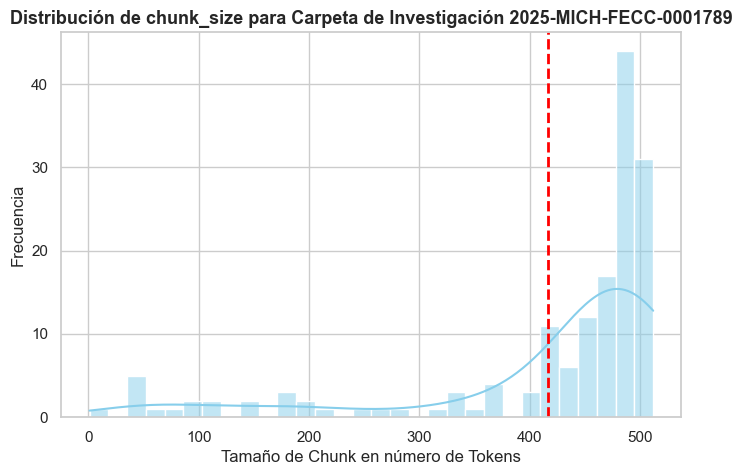

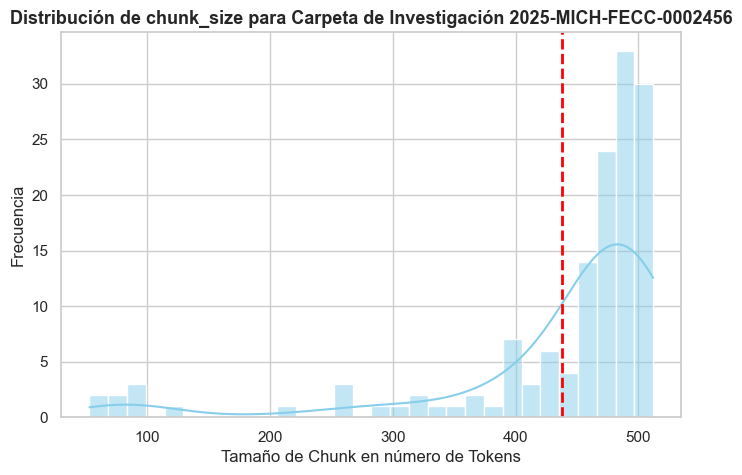

In [23]:
# Información del tamaño de chunks del DataFrame
for key, df in carpetas_chunks_dfs.items():
    plot_chunks(df, f"Carpeta de Investigación {key}")

In [24]:
# Procesamiento de metadatos de archivos de marco jurídico y vista previa

# 1) Generación de DataFrame chunks
marco_juridico_chunks_df = process_text_and_generate_chunks(marco_juridico_df, are_legal_structures=True)

# 2) Información general del DataFrame
marco_juridico_chunks_df.info()

100%|██████████| 24/24 [02:24<00:00,  6.03s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11828 entries, 0 to 11827
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc         11828 non-null  object
 1   text        11828 non-null  object
 2   chunk_size  11828 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.3+ KB


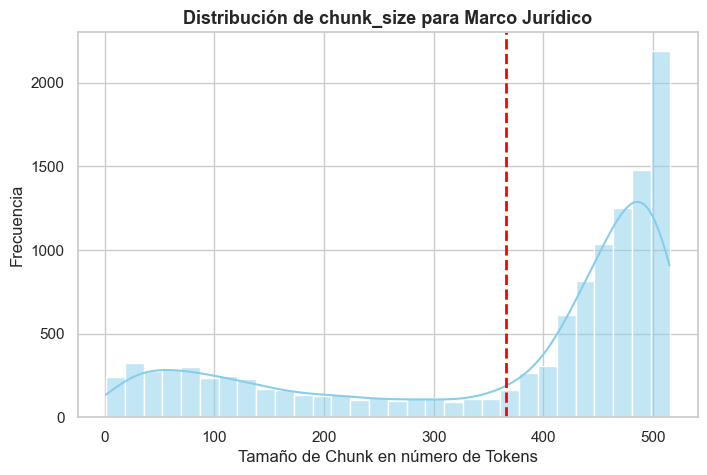

In [25]:
# Información del tamaño de chunks del DataFrame
plot_chunks(marco_juridico_chunks_df, "Marco Jurídico")

# 4. Generación de *Embeddings*

En el presente trabajo, como se desarrolló en la sección del *preprocesamiento del corpus de texto*, se obtuvieron *chunks* de diferentes dimensiones en su ventana de contexto, es decir, de diferentes dimensiones pero con un límite en los 512 *tokens* por *chunk*. Esto último, como consecuencia de la lógica de su procesamiento, pues a los textos de **Carpetas de Investigación**, al ser textos menos rígidos y un poco más homogéneos en su volumen, se procedió a generar *chunks* de un tamaño estándar tomando en cuenta un proceso de *overlapping* espacial para conservar contexto entre *chunks* adyacentes. Por su parte, los textos del **Marco Jurídico**, al ser documentos más rígidos en su estructura, se procesaron mediante un *chunking* basado en estructuras (artículos, capítulos, libros, etc.), lo cual al final produjo *chunks* que representaron estructuras, conservando el contexto, pero haciendo de estos segmentos muy variables en tamaño, aunque con un límite en 512 *tokens* por *chunk*, con el mismo proceso de *overlapping* de los documentos de **Carpetas de Investigación**. En general, para ambos tipos de documentos se utilizaron ventanas estándar con el objetivo de preservar el mayor contexto de manera granular pero sin fragmentarlo mucho.

Para tener eficiencia en el uso de recursos, una uniformidad en el procesamiento de documentos sin importar su naturaleza y un mismo proceso de vectorización de *chunks* que pueden llegar a 512 *tokens* por *chunk*, se optó por el uso de un mismo modelo de *embeddings*.

El modelo que se seleccionó fue `nomic-ai/nomic-embed-text-v1.5`, propuesto en el artículo "*Nomic Embed: Training a Reproducible Long Context Text Embedder*" (Nussbaum et al., 2024). Este modelo está diseñado para manejar contextos largos de hasta 8,192 *tokens*, superando el rendimiento de otros modelos de *embeddings* *open-source* líderes (como `OpenAI Ada-002` y `text-embedding-3-small`) en tareas de contexto corto y largo. Se basa en una arquitectura de transformador optimizada para recuperación de información y aprendizaje contrastivo, lo que le permite distinguir entre representaciones similares y representaciones disímiles. Este modelo fue entrenado con grandes conjuntos de datos de pares de texto para capturar relaciones semánticas complejas. La elección de `nomic-embed-text-v1.5` permite vectorizar *chunks* de hasta 512 *tokens* con alta fidelidad semántica derivado de las características de la arquitectura y entrenamiento del modelo. Por tanto, al estar optimizado para tareas de recuperación como es el caso de este proyecto y poder entregar espacios vectoriales de alta fidelidad sin importar las dimensiones de los documentos y *chunks* de estos (como es el caso de este proyecto manejando documentos de diversos tamaños y naturaleza), se decidió por la elección de este mismo.

Aparte, junto con el modelo de *embeddings* antes descrito, se utilizó la estrategia *Matryoshka Representation Learning* o *MRL* descrita en el artículo llamado "*Matryoshka Representation Learning*" (Kusupati et al., 2024). Esta estrategia permite que los *embeddings* generados por `nomic-embed-text-v1.5` sean **truncables** a dimensiones más pequeñas sin una pérdida significativa de calidad en la recuperación semántica. Así, en el caso de este proyecto, se pasó de 768 dimensiones originales a 512 dimensiones por *embedding* generado. El uso de *MRL* se integra como una medida de optimización de recursos y latencia. Esto garantiza la uniformidad en el procesamiento, pero otorga la flexibilidad necesaria para ajustar el balance entre precisión y velocidad en el sistema de recuperación, aspecto crucial al manejar un volumen creciente de documentos con distintas estructuras.

En resumen, la combinación del modelo `nomic-embed-text-v1.5` con la estrategia *Matryoshka Representation Learning* permitió construir un sistema de *embeddings* eficiente, coherente y escalable, capaz de manejar documentos de diferentes naturalezas y tamaños, preservando el contexto y la relevancia semántica de los textos legales. Esta integración asegura que los *chunks* generados de **Carpetas de Investigación** y del **Marco Jurídico** puedan compararse y recuperarse de manera consistente, optimizando tanto el uso de recursos como la precisión en tareas de búsqueda, análisis y recuperación de información dentro del corpus.

In [26]:
def mean_pooling(model_output, attention_mask):
    """
    Aplica una operación de pooling promedio (mean pooling) sobre las salidas del modelo de embeddings,
    ponderando los vectores de tokens según la máscara de atención. 
    Este proceso obtiene una representación vectorial promedio del texto completo.

    Parámetros:
        model_output (tuple[torch.Tensor, ...]) : Salida del modelo, donde el primer elemento 
                                                  contiene las representaciones de los tokens.
        attention_mask (torch.Tensor)           : Máscara binaria que indica qué tokens son válidos (1)
                                                  y cuáles deben ignorarse (0) en el cálculo promedio.

    Retorno:
        torch.Tensor : Vector resultante del pooling promedio, de dimensión (batch_size, embedding_dim),
                        representando el embedding agregado del texto completo.
    """

    # 1) Obtención de embeddings de tokens
    #    Extrae las representaciones por token del primer elemento de la salida del modelo
    token_embeddings = model_output[0]

    # 2) Expansión de la máscara de atención
    #    Expande la máscara para que coincida con las dimensiones del tensor de embeddings y convierte a tipo float
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    # 3) Cálculo del pooling promedio ponderado
    #    Multiplica cada embedding por su máscara, suma los vectores válidos y divide entre el número de tokens válidos
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [27]:
def generate_embeddings(input_data, embed_model=EMBED_MODEL, tokenizer=EMBED_TOKENIZER, matryoshka_dim=MATRYOSHKA_DIM, batch_size=16, device=DEVICE):
    """
    Genera embeddings numéricos para uno o varios textos utilizando un modelo de lenguaje preentrenado.
    Soporta tanto entradas individuales como listas de textos y devuelve un DataFrame con los vectores resultantes.

    Parámetros:
        input_data (str | list[str])    : Texto individual o lista de textos a convertir en embeddings.
        embed_model (PreTrainedModel)   : Modelo de embeddings previamente cargado (por defecto EMBED_MODEL).
        tokenizer (PreTrainedTokenizer) : Tokenizador asociado al modelo (por defecto EMBED_TOKENIZER).
        matryoshka_dim (int, opcional)  : Dimensión del embedding final después del recorte. Por defecto 512.
        batch_size (int, opcional)      : Tamaño del lote de procesamiento. Por defecto 16.
        device (str, opcional)          : Dispositivo donde se ejecuta el modelo ('cpu' o 'cuda'). Por defecto DEVICE.

    Retorno:
        pd.DataFrame : DataFrame donde cada fila representa el embedding normalizado de un texto.
    """

    # 1) Validación y preparación de las entradas
    if isinstance(input_data, str):                                             # Caso de texto individual
        if not input_data.strip():                                              # Si el texto está vacío o solo contiene espacios
            raise ValueError("El texto proporcionado está vacío.")
        sentences = [f"search_query: {input_data}"]                             # Prefijo semántico para consultas
    elif isinstance(input_data, list):                                          # Caso de lista de textos
        if len(input_data) == 0:                                                # Si la lista está vacía
            raise ValueError("La lista está vacía.")
        sentences = [f"search_document: {text}" for text in input_data]         # Prefijo semántico para documentos
    else:
        raise ValueError("El input debe ser una cadena o una lista de textos.") # Tipo de dato inválido

    # 2) Inicialización del contenedor de embeddings
    all_embeddings = []

    # 3) Generación de embeddings por lotes
    for i in tqdm(range(0, len(sentences), batch_size), desc="Generando embeddings", leave=False):
        batch_sentences = sentences[i:i+batch_size] # Selecciona el lote actual de oraciones
        encoded_input = tokenizer(                  # Tokeniza las oraciones con padding y truncado
            batch_sentences, 
            padding=True, 
            truncation=True, 
            return_tensors='pt'
        ).to(device)                                # Mueve los tensores al dispositivo de cómputo

        # 4) Inferencia sin gradientes
        with torch.no_grad():  
            model_output = embed_model(**encoded_input)                                 # Obtiene las representaciones del modelo
            batch_emb = mean_pooling(model_output, encoded_input['attention_mask'])     # Aplica pooling promedio
            batch_emb = F.layer_norm(batch_emb, normalized_shape=(batch_emb.shape[1],)) # Normalización por capa
            batch_emb = batch_emb[:, :matryoshka_dim]                                   # Recorta la dimensión del embedding
            batch_emb = F.normalize(batch_emb, p=2, dim=1)                              # Normaliza cada embedding (norma L2)
            all_embeddings.append(batch_emb.cpu().numpy())                              # Mueve a CPU y convierte a numpy

    # 5) Consolidación de resultados
    embeddings = np.vstack(all_embeddings)      # Une todos los embeddings en una sola matriz
    embeddings_df = pd.DataFrame(embeddings)    # Convierte los embeddings en un DataFrame de Pandas

    # 6) Retorno final
    return embeddings_df

In [28]:
# Bloque de generación y visualización de embeddings

# 1) Generación de embeddings para los chunks de carpetas con batch size de 64
carpetas_embeddings_dfs = {
    key: generate_embeddings(value['text'].tolist())
    for key, value in carpetas_chunks_dfs.items()
}

# 2) Mostrar las primeras filas del DataFrame de embeddings para inspección rápida
for key, df in carpetas_embeddings_dfs.items():
    print(f"\n=== Embeddings de Carpeta de Investigación: {key} ===\n")
    display(df.head())


=== Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0001789 ===



,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.071453,0.048465,-0.223351,0.010284,0.004656,-0.053085,-0.030725,-0.052328,-0.007003,0.034327,...,-0.005564,0.011729,0.063698,-0.061000,0.047994,-0.034632,-0.085747,0.030396,-0.031284,-0.020375
1,0.081659,0.071223,-0.200473,-0.029142,0.001289,-0.044566,-0.001370,0.005577,-0.006188,0.020717,...,0.009051,-0.003066,0.087312,-0.043164,0.060429,-0.005595,-0.058470,0.017992,-0.014200,0.031230
2,0.075204,0.089440,-0.208227,0.007361,0.054843,-0.054796,0.012072,-0.009416,-0.015692,0.044755,...,-0.017292,-0.035250,0.112228,-0.015137,0.052185,0.005734,-0.055377,-0.013128,-0.043604,0.037041
3,0.075960,0.060257,-0.208119,0.016953,0.040074,-0.033250,-0.004793,-0.024047,-0.014888,-0.001778,...,0.006554,-0.020157,0.046562,-0.029176,0.051362,-0.005483,-0.043816,-0.009456,-0.001108,0.040220
4,0.090221,0.049893,-0.215388,-0.030414,0.057063,-0.060528,0.011141,-0.004522,0.040787,0.018418,...,-0.014266,0.006772,0.045850,-0.070165,0.040535,-0.044039,-0.055498,0.002875,-0.028650,0.007954



=== Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0002456 ===



,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.068939,0.053681,-0.216948,-0.007151,0.006325,-0.048824,-0.028882,-0.060414,-0.036060,0.032923,...,-0.007143,0.002792,0.090523,-0.065119,0.058471,-0.054001,-0.072045,0.038550,-0.029705,-0.014036
1,0.097470,0.051088,-0.195431,-0.022405,0.018810,-0.045050,0.005305,-0.034899,-0.017961,0.020119,...,-0.001724,-0.031137,0.057475,-0.002315,0.025632,0.001182,-0.061760,0.015562,-0.012908,0.000195
2,0.080228,0.079624,-0.210244,0.022377,0.015702,-0.068497,-0.015192,-0.043166,0.000457,0.015973,...,0.004058,-0.005786,0.121911,-0.043363,0.066211,-0.007220,-0.052602,0.003701,-0.057157,0.008515
3,0.098567,0.062982,-0.203185,-0.007072,0.012463,-0.040520,-0.014161,-0.001825,0.002423,0.022651,...,-0.001430,-0.017705,0.059891,-0.035631,0.051707,-0.022191,-0.089384,0.000695,-0.041036,0.028582
4,0.130676,0.097792,-0.177857,-0.007602,0.060049,-0.058534,0.030735,-0.036814,-0.009145,-0.034198,...,0.022467,-0.032123,0.068257,-0.038993,0.090362,-0.042583,-0.066639,0.039741,-0.007024,0.002700


In [29]:
# Información general del DataFrame
for key, df in carpetas_embeddings_dfs.items():
    print(f"\n=== Información de los Embeddings de Carpeta de Investigación: {key} ===\n")
    display(df.info())


=== Información de los Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0001789 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Columns: 512 entries, 0 to 511
dtypes: float32(512)
memory usage: 312.1 KB


None


=== Información de los Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0002456 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Columns: 512 entries, 0 to 511
dtypes: float32(512)
memory usage: 284.1 KB


None

In [30]:
# Bloque de generación y visualización de embeddings

# 1) Generación de embeddings para los chunks de carpetas con batch size de 16
marco_juridico_embeddings_df = generate_embeddings(marco_juridico_chunks_df['text'].tolist())

# 2) Mostrar las primeras filas del DataFrame de embeddings para inspección rápida
marco_juridico_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.006571,0.034581,-0.214807,-0.004561,-0.014263,-0.060729,-0.004277,-0.049035,-0.012027,-0.024994,...,-0.014468,0.002123,0.097351,-0.090173,0.022809,-0.021507,-0.070584,0.010945,-0.032000,0.013409
1,0.088321,0.037305,-0.155773,-0.002128,0.008152,-0.045437,-0.004806,-0.060977,0.004103,0.035752,...,-0.002142,-0.034036,0.032523,-0.077447,0.034939,-0.038326,-0.057537,-0.008597,-0.049631,0.004322
2,0.116821,0.037362,-0.191788,0.001636,0.015231,-0.005954,0.016212,-0.051514,-0.012775,0.029254,...,-0.013272,-0.004428,0.034408,-0.077255,0.072393,-0.037725,-0.055785,0.014336,-0.060925,0.009042
3,0.091814,0.040616,-0.157423,-0.002375,0.062453,-0.033749,-0.003660,-0.050472,-0.012499,0.013114,...,-0.006395,-0.000878,0.019776,-0.062013,0.050129,-0.051645,-0.047976,0.000671,-0.038599,-0.001133
4,0.086341,0.056557,-0.171534,-0.013654,0.002255,-0.026876,0.002251,-0.046632,-0.026584,0.031365,...,0.015423,-0.010841,0.003788,-0.038463,0.027569,-0.042792,-0.061378,0.019440,-0.038264,-0.000980


In [31]:
# Información general del DataFrame
marco_juridico_embeddings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11828 entries, 0 to 11827
Columns: 512 entries, 0 to 511
dtypes: float32(512)
memory usage: 23.1 MB


# 5. Modelos Alternativos

En la presente sección, se configuran, evalúan y analizan diferentes modelos, llamados **modelos alternativos**. Así pues, la solución que se implementará propone el desarrollo de un sistema ***RAG*** que contempla la integración de un modelo ***LLM***, de un modelo ***Cross-Encoder*** y de un motor de **Base de Datos Vectorial**. En consecuencia, los **modelos alternativos** que se proponen son tanto diferentes modelos de ***Cross-Encoders*** como modelos ***LLMs***.

En primer lugar, los ***Large Language Models*** o ***LLMs*** son arquitecturas poderosas basadas en *Transformers*, entrenadas con objetivos genéricos de modelado de lenguaje (por ejemplo, predicción de palabra siguiente). Como lo señalan Loo et al. (2026), estos modelos capturan patrones lingüísticos amplios, pero carecen muchas veces del conocimiento específico y actualizado necesario para dominios como el jurídico.

Para superar esa limitación, el paradigma de ***Retrieval-Augmented Generation*** o ***RAG*** propone una simbiosis entre recuperación de información y generación de lenguaje (Aytar et al., 2025). En esencia, un modelo ***RAG*** permite que un ***LLM*** busque fragmentos relevantes de un corpus externo (por medio de un mecanismo de recuperación semántica) y los incorpore como contexto para producir una respuesta más informada, precisa y fundamentada. En muchas industrias como la legal, esta integración ha probado su valor al mejorar respuestas especializadas que un ***LLM*** sin contexto fallaría en responder correctamente.

Asimismo, un sistema ***RAG*** típico opera en tres fases (Gao et al., 2024):

1. **Indexación**: los documentos (o fragmentos textuales) se dividen en *chunks*, se transforman en vectores (*embeddings*) y se almacenan en una base de datos vectorial.
2. **Recuperación**: ante una consulta, el sistema busca los *k* fragmentos más similares semánticamente.
3. **Generación**: la pregunta original junto con esos fragmentos recuperados se alimentan al modelo de lenguaje, que genera la respuesta final.

Un ***RAG*** puede sintetizar información contextual, precisa y actualizada. Sin embargo, los sistemas ***RAG*** pueden fallar en la recuperación de documentos relevantes. Existen distintas técnicas que pueden solucionar este problema, como el *reranking* o la **codificación cruzada** ***Cross-Encoding*** (Barnett et al., 2024).

El **reranking de documentos** es una tarea central en la recuperación de información, cuyo objetivo es evaluar la relevancia del conjunto de los $k$ documentos recuperados por un primer sistema (por ejemplo, una **Base de Datos Vectorial**) y generar una lista de documentos con un orden mejorado (Xiong et al., 2025). Un *reranker* robusto también beneficia el proceso de lectura al identificar eficazmente los documentos positivos (relevantes) y elevarlos a posiciones destacadas en la clasificación (Dong, 2024).

Así pues, para el desarrollo de este proyecto, la **Base de Datos Vectorial** seleccionada es **Qdrant**, derivado de su flexibilidad al poderse utilizar tanto de manera local, en microservicios o en la nube. Por otra parte, no existe mucha diferencia entre los mecanismos usados por **Qdrant** y otros proveedores en el mercado.

**Qdrant** es un motor de búsqueda vectorial de alto rendimiento y base de datos especializada para vectores de alta dimensión, escrita en *Rust*, optimizada para manejar búsquedas semánticas con eficiencia y escalabilidad. Ofrece una *API* ligera para almacenar vectores y su metadata, y soporta métricas de distancia esenciales como **Cosine**, **Dot Product** y euclídea. Su diseño lo hace ideal como centro del componente *retriever* de un sistema ***RAG***, pues se adapta bien a esquemas de producción, escala bien y es relativamente sencillo de desplegar (Qdrant, 2023).

En este sistema ***RAG*** se utiliza ***Cosine Similarity*** como medida de similitud entre *embeddings*. La medida de similitud coseno o ***Cosine Similarity*** (***CSM***) es una métrica para calcular la similitud de dos vectores en un espacio multidimensional. Se calcula como el coseno del ángulo entre dos vectores. ***CSM*** es ampliamente utilizada en muchos campos, incluyendo la recuperación de información, el procesamiento del lenguaje natural y la minería de datos, para determinar la similitud de materiales, textos o puntos de datos (Rahim et al., 2024). La fórmula es:

$$\text{Similitud Coseno}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{|\mathbf{A}| |\mathbf{B}|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$$

Esta fórmula calcula el coseno del ángulo entre dos vectores, $\mathbf{A}$ y $\mathbf{B}$, en un espacio *$n$-dimensional*:

* **Numerador ($\mathbf{A} \cdot \mathbf{B}$):** representa el **producto punto** (*dot product*) de los vectores $\mathbf{A}$ y $\mathbf{B}$.
* **Denominador ($|\mathbf{A}| |\mathbf{B}|$):** es el producto de las **magnitudes** (o norma euclidiana) de los vectores $\mathbf{A}$ y $\mathbf{B}$.

El resultado siempre estará entre **-1** (perfectamente opuestos) y **1** (perfectamente iguales), donde un valor de **1** indica máxima similitud temática.

Otras métricas posibles serían *dot product* (producto punto) o distancia euclidiana, pero estas suelen ser más sensibles a la magnitud de los vectores. En *embeddings* semánticos, como es el caso de este trabajo, donde la dirección codifica significado y no la longitud, ***Cosine Similarity*** es la opción más robusta y ampliamente utilizada en sistemas ***RAG***.

Para el modelo ***LLM*** se utilizarán 4 diferentes modelos robustos entrenados con entre 7 y 9 billones de parámetros, lo que los hace funcionales en la tarea de integrar e interpretar documentos recuperados mediante la **Base de Datos Vectorial** y los modelos ***Cross-Encoder***. Además, esta amplitud de parámetros de entrenamiento les da la característica de entregar respuestas más coherentes, lógicas y comprensibles. Los modelos a utilizar son:

* `llama3.1:8b`: desarrollado por *Meta AI*, es un modelo de lenguaje optimizado para tareas de razonamiento, comprensión y generación de texto en múltiples idiomas. Su arquitectura está ajustada para manejar contextos largos y mantener coherencia semántica (Hugging Face, 2024b).
* `mistral:7b`: creado por *Mistral AI*, destaca por su eficiencia computacional y su capacidad para generar texto de alta calidad con un tamaño de modelo moderado. Es especialmente útil en escenarios donde se requiere un balance entre rendimiento y velocidad (Hugging Face, 2023).
* `gemma2:9b`: modelo de *Google DeepMind*, entrenado con un corpus diverso y multilingüe que le permite ofrecer interpretaciones semánticas más amplias y detalladas. Su fortaleza radica en la comprensión profunda de estructuras textuales complejas (Hugging Face, 2024a).
* `qwen2:7b`: desarrollado por *Alibaba Cloud*. En general, ha superado la mayoría de los modelos de código abierto y ha demostrado competitividad frente a los modelos propietarios en una serie de puntos de referencia orientados a la comprensión del lenguaje, la generación del lenguaje, la capacidad multilingüe, la codificación, las matemáticas, el razonamiento, etc. (Hugging Face, 2025g).

En cuanto al modelo ***Cross-Encoder***, se utilizarán 6 diferentes modelos con distintas capas de atención o *Transformer Layers*, lo que hace que varíen en eficiencia y costo. Los modelos utilizados están basados en *BERT*, como son *MiniLM* y *TinyBERT*, que han sido optimizados mediante destilación de conocimiento (*Knowledge Distillation*) para reducir drásticamente su tamaño y complejidad. Estos modelos se emplean para evaluar la relevancia entre una consulta y los fragmentos de texto recuperados desde la ***Base de Datos Vectorial***, generando una puntuación que permite reordenar los resultados con mayor precisión semántica:

* `cross-encoder/ms-marco-MiniLM-L2-v2`: modelo ligero con dos capas de atención (*Transformer layers*), diseñado para ofrecer respuestas rápidas (Hugging Face, 2025a).
* `cross-encoder/ms-marco-MiniLM-L4-v2`: balancea eficiencia y precisión, con cuatro capas de atención, siendo ideal para etapas de *reranking* intermedias donde el costo computacional debe mantenerse bajo (Hugging Face, 2025b).
* `cross-encoder/ms-marco-MiniLM-L6-v2`: ofrece un rendimiento robusto para tareas de *semantic ranking* con 6 capas de atención, manteniendo una estructura ligera pero con mayor capacidad contextual (Hugging Face, 2025c).
* `cross-encoder/ms-marco-MiniLM-L12-v2`: la versión más profunda de la familia *MiniLM*, con doce capas, proporciona un análisis más exhaustivo de las relaciones semánticas entre consulta y texto (Hugging Face, 2025d).
* `cross-encoder/ms-marco-TinyBERT-L2-v2`: basado en una versión reducida del modelo *BERT*, con solo dos capas, está optimizado para escenarios de baja latencia, permitiendo su integración en sistemas que requieren respuesta inmediata (Hugging Face, 2025e).
* `cross-encoder/ms-marco-TinyBERT-L4`: incrementa la profundidad a cuatro capas respecto a su versión anterior, logrando una mejor representación semántica con un impacto mínimo en el rendimiento (Hugging Face, 2025f).

## 5.1. Configuración

### a) Base de Datos Vectorial

In [32]:
# Construcción del diccionario principal de colecciones con embeddings y textos
collections = {
    "marco_juridico": {
        "embeddings": marco_juridico_embeddings_df.values.tolist(),     # Conversión de embeddings del marco jurídico a lista
        "text": marco_juridico_chunks_df["text"].values.tolist(),       # Lista de textos correspondientes
        "doc": marco_juridico_chunks_df["doc"].values.tolist()          # Lista de documentos de origen
    },
    **{
        key: {
            "embeddings": carpetas_embeddings_dfs[key].values.tolist(), # Embeddings de cada carpeta individual
            "text": carpetas_chunks_dfs[key]["text"].values.tolist(),   # Textos chunkificados por carpeta
            "doc": carpetas_chunks_dfs[key]["doc"].values.tolist()      # Documentos originales asociados
        }
        for key in carpetas_embeddings_dfs.keys()                       # Iteración sobre todas las carpetas con embeddings
    }
}

In [33]:
def init_vector_db(collections, embeddings_size=512):
    """
    Inicializa una base de datos vectorial en memoria usando Qdrant e ingresa las colecciones proporcionadas.

    Parámetros:
        collections (dict) : Diccionario que contiene las colecciones de embeddings, textos y documentos,
                             con la siguiente estructura:
                             {"nombre_coleccion": {"embeddings": [...], "text": [...], "doc": [...]}}

    Retorno:
        QdrantClient | None : Instancia del cliente Qdrant con las colecciones cargadas,
                              o None si ocurre un error en la conexión o configuración.
    """

    # 1) Intentar establecer la conexión con Qdrant en memoria
    try:
        vector_db = QdrantClient(":memory:")                    # Se crea una instancia del cliente Qdrant en memoria
        print(f"Conectado correctamente a Qdrant.")
    except Exception as e:
        print(f"No se pudo conectar a Qdrant: {e}")
        return None                                             # Retorna None si la conexión falla

    # 2) Crear colecciones y subir sus embeddings
    for name, data in collections.items():                      # Iteración sobre cada colección del diccionario
        try:
            vector_db.create_collection(                        # Recrear o crear una colección desde cero
                collection_name=name,
                vectors_config=models.VectorParams(
                    size=embeddings_size,                       # Dimensión del embedding (tamaño fijo del modelo)
                    distance=models.Distance.COSINE             # Métrica de similitud basada en el coseno
                )
            )
            print(f"Colección '{name}' creada correctamente.")
        except Exception as e:
            print(f"No se pudo crear la colección '{name}': {e}")
            continue                                            # Se continúa con la siguiente colección

        # 3) Subida de los embeddings y metadatos asociados
        try:
            embeddings = data["embeddings"]                     # Recuperar embeddings de la colección
            payload = [
                {"text": text, "doc": doc}                      # Se asocia cada vector con su texto y documento
                for text, doc in zip(data["text"], data["doc"])
            ]

            vector_db.upload_collection(                        # Subida masiva de vectores a la colección
                collection_name=name,
                vectors=embeddings,
                payload=payload,
                ids=list(range(len(embeddings)))                # IDs secuenciales para cada vector
            )
        except Exception as e:
            print(f"Error subiendo vectores a '{name}': {e}")   # Manejo de error en la carga de vectores

    # 4) Confirmación final del pro
    print("\nVector DB generada correctamente.")                # Mensaje final de éxito
    return vector_db                                            # Retorna la instancia de la base de datos vectorial

In [34]:
# Inicialización de la base de datos vectorial
vector_db = init_vector_db(collections)

Conectado correctamente a Qdrant.
Colección 'marco_juridico' creada correctamente.
Colección '2025-MICH-FECC-0001789' creada correctamente.
Colección '2025-MICH-FECC-0002456' creada correctamente.

Vector DB generada correctamente.


### b) Modelos *Cross-Encoder*

In [35]:
def init_crossencoder(model_name, device=DEVICE):
    """
    Inicializa un modelo Cross-Encoder para tareas de comparación o clasificación de pares de texto.
    Detecta automáticamente si se debe usar GPU (CUDA) o CPU para cargar el modelo.

    Parámetros:
        model_name (str) : Nombre del modelo de Cross-Encoder a cargar (por ejemplo, "cross-encoder/ms-marco-MiniLM-L-6-v2").

    Retorno:
        CrossEncoder : Instancia del modelo cargado y listo para su uso.
    """

    # 1) Intento de carga del modelo con manejo de errores
    try:
        print(f"Cargando modelo Cross-Encoder '{model_name}' en dispositivo: {device}.")
        model = CrossEncoder(model_name, device=device) # Inicializa el modelo en el dispositivo correspondiente
        print(f"Cross-Encoder inicializado correctamente ({model_name}).")
    except Exception as e:
        raise RuntimeError(f"No se pudo inicializar el modelo '{model_name}': {str(e)}.")

    # 2) Retorno del modelo cargado
    return model

In [36]:
# Inicialización de modelos Cross-Encoder

# 1) Definición de los nombres de modelos Cross-Encoder a utilizar
cross_encoder_models = [
    "cross-encoder/ms-marco-MiniLM-L2-v2",
    "cross-encoder/ms-marco-MiniLM-L4-v2",
    "cross-encoder/ms-marco-MiniLM-L6-v2",
    "cross-encoder/ms-marco-MiniLM-L12-v2",
    "cross-encoder/ms-marco-TinyBERT-L2-v2",
    "cross-encoder/ms-marco-TinyBERT-L4"
]

# 2) Inicialización de instancias de clientes para cada modelo
cross_encoder_clients = {}

for model_name in cross_encoder_models:
    print(f"\n=== Inicializando modelo Cross-Encoder: {model_name} ===\n")  # Mensaje de estado para seguimiento
    cross_encoder_clients[model_name] = init_crossencoder(model_name)       # Carga e inicialización del modelo


=== Inicializando modelo Cross-Encoder: cross-encoder/ms-marco-MiniLM-L2-v2 ===

Cargando modelo Cross-Encoder 'cross-encoder/ms-marco-MiniLM-L2-v2' en dispositivo: cpu.
Cross-Encoder inicializado correctamente (cross-encoder/ms-marco-MiniLM-L2-v2).

=== Inicializando modelo Cross-Encoder: cross-encoder/ms-marco-MiniLM-L4-v2 ===

Cargando modelo Cross-Encoder 'cross-encoder/ms-marco-MiniLM-L4-v2' en dispositivo: cpu.
Cross-Encoder inicializado correctamente (cross-encoder/ms-marco-MiniLM-L4-v2).

=== Inicializando modelo Cross-Encoder: cross-encoder/ms-marco-MiniLM-L6-v2 ===

Cargando modelo Cross-Encoder 'cross-encoder/ms-marco-MiniLM-L6-v2' en dispositivo: cpu.
Cross-Encoder inicializado correctamente (cross-encoder/ms-marco-MiniLM-L6-v2).

=== Inicializando modelo Cross-Encoder: cross-encoder/ms-marco-MiniLM-L12-v2 ===

Cargando modelo Cross-Encoder 'cross-encoder/ms-marco-MiniLM-L12-v2' en dispositivo: cpu.
Cross-Encoder inicializado correctamente (cross-encoder/ms-marco-MiniLM-L1

### c) Modelos *LLM*

In [37]:
class OllamaClient:
    """
    Cliente para interactuar con el servidor Ollama a través de su API HTTP.
    Proporciona métodos para verificar la conexión, listar modelos disponibles,
    descargar modelos y generar texto a partir de prompts utilizando modelos locales.

    Atributos:
        base_url (str) : URL base del servidor Ollama, utilizada para construir las rutas de las solicitudes.
    """

    def __init__(self, base_url=OLLAMA_BASE_URL):
        """
        Inicializa el cliente estableciendo la URL base del servidor Ollama.

        Parámetros:
            base_url (str, opcional) : Dirección base del servidor Ollama. 
                                       Por defecto se toma la constante OLLAMA_BASE_URL.
        """
        self.base_url = base_url.rstrip("/") # Elimina cualquier barra final para evitar duplicaciones en las rutas
    
    def is_alive(self):
        """
        Verifica si el servidor Ollama está en línea realizando una solicitud GET a su API.

        Retorno:
            bool : True si el servidor responde correctamente (status 200), False en caso contrario.
        """
        try:
            resp = requests.get(f"{self.base_url}/api/tags", timeout=3) # Realiza una solicitud de prueba
            return resp.status_code == 200                              # Devuelve True si la conexión fue exitosa
        except Exception:
            return False                                                # En caso de error o timeout, devuelve False
    
    def list_models(self):
        """
        Obtiene la lista de modelos disponibles en el servidor Ollama.

        Retorno:
            list[dict] : Lista de diccionarios que describen los modelos disponibles.
        """
        resp = requests.get(f"{self.base_url}/api/tags")    # Solicita la lista de modelos
        resp.raise_for_status()                             # Lanza excepción si ocurre un error HTTP
        return resp.json().get("models", [])                # Devuelve la lista de modelos (vacía si no hay)
    
    def pull_model(self, model_name):
        """
        Descarga o actualiza un modelo específico desde Ollama.

        Parámetros:
            model_name (str) : Nombre del modelo a descargar.

        Retorno:
            dict : Respuesta JSON de la API con información del proceso de descarga.
        """
        payload = {"name": model_name}                                  # Cuerpo de la solicitud con el nombre del modelo
        resp = requests.post(f"{self.base_url}/api/pull", json=payload) # Envía la solicitud POST a la API
        resp.raise_for_status()                                         # Verifica que la respuesta no contenga errores
        return resp.json()                                              # Devuelve la respuesta decodificada en formato JSON
    
    def generate(self, model_name, prompt, stream=False, **kwargs):
        """
        Genera texto a partir de un prompt usando un modelo cargado en Ollama.

        Parámetros:
            model_name (str)  : Nombre del modelo a utilizar para la generación.
            prompt (str)      : Texto de entrada que define la instrucción o contexto.
            stream (bool)     : Indica si la respuesta se recibe en flujo (streaming). Por defecto False.
            **kwargs          : Argumentos adicionales opcionales para personalizar la generación.

        Retorno:
            dict : Respuesta JSON de la API con el texto generado por el modelo.
        """
        payload = {"model": model_name, "prompt": prompt, "stream": stream}                 # Construye el cuerpo base de la solicitud
        payload.update(kwargs)                                                              # Agrega parámetros opcionales si se proporcionan
        resp = requests.post(f"{self.base_url}/api/generate", json=payload, timeout=1000)   # Envía la solicitud al servidor
        resp.raise_for_status()                                                             # Lanza error si la respuesta es inválida
        return resp.json()                                                                  # Devuelve la salida del modelo como diccionario


In [38]:
def restart_ollama_container(model_name):
    """
    Reinicia el contenedor Docker del servidor Ollama para asegurar que el modelo
    esté cargado correctamente y el servicio disponible. Ejecuta un script externo
    para iniciar el contenedor y espera un breve periodo antes de continuar.

    Parámetros:
        model_name (str) : Nombre del modelo que se desea asegurar esté disponible 
                           tras el reinicio del contenedor.

    Retorno:
        None : Solo realiza operaciones de reinicio y espera; no devuelve valor.
    """

    # 1) Detención y eliminación del contenedor Ollama existente
    subprocess.run(["docker", "stop", "ollama"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)    # Detiene el contenedor
    subprocess.run(["docker", "rm", "ollama"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)      # Elimina el contenedor

    # 2) Inicio del contenedor usando script externo
    subprocess.run([
        "./start_ollama.sh" # Script que inicia el contenedor Ollama con el modelo deseado
    ], check=True)          # Lanza excepción si el script falla

    # 3) Espera para asegurar que el contenedor y el modelo estén listos
    time.sleep(5)

In [39]:
def init_llm_model_ollama(model_name, base_url=OLLAMA_BASE_URL):
    """
    Inicializa un modelo de lenguaje local (LLM) usando el servidor Ollama.
    Verifica la conexión al servidor, descarga el modelo si no está disponible 
    y devuelve una función para generar texto a partir de prompts.

    Parámetros:
        model_name (str)         : Nombre del modelo LLM que se desea inicializar.
        base_url (str, opcional) : URL base del servidor Ollama. Por defecto OLLAMA_BASE_URL.

    Retorno:
        function : Función llm_generate(prompt, **kwargs) que permite generar texto usando el modelo inicializado.
    """

    # 1) Creación del cliente Ollama
    client = OllamaClient(base_url=base_url)  # Inicializa el cliente con la URL base del servidor

    # 2) Verificación de disponibilidad del servidor
    if not client.is_alive():  # Comprueba si el servidor responde correctamente
        raise RuntimeError(f"Ollama server no responde en {base_url}. Asegúrate de que esté corriendo.")

    # 3) Comprobación de disponibilidad del modelo
    models = [m["name"] for m in client.list_models()]  # Obtiene los nombres de los modelos disponibles
    if model_name not in models:                        # Si el modelo no está presente en el servidor
        print(f"Modelo '{model_name}' no encontrado en Ollama. Realizando pull...")  
        client.pull_model(model_name)                   # Descarga el modelo
        time.sleep(5)                                   # Pausa breve para asegurar que el modelo esté listo

    # 4) Definición de la función generadora de texto
    def llm_generate(prompt, **kwargs):
        """
        Función interna para generar texto usando el modelo inicializado.

        Parámetros:
            prompt (str) : Texto de entrada que guía la generación.
            **kwargs     : Parámetros adicionales opcionales para la generación.

        Retorno:
            dict : Respuesta JSON del modelo con el texto generado.
        """
        return client.generate(model_name, prompt, **kwargs)  # Llama a la API de generación de Ollama

    # 5) Retorno de la función generadora
    return llm_generate

In [40]:
# Definición de modelos LLM disponibles
llm_models = [
    "llama3.1:8b",
    "mistral:7b",
    "gemma2:9b",
    "qwen2:7b"
]

### d) Configuración Sistema *RAG*

In [41]:
def vector_db_retriever(query, collection, vector_db, embed_model=EMBED_MODEL, top_k=25):
    """
    Recupera los puntos más relevantes de una base de datos vectorial dado un query textual.

    Parámetros:
        query (str)                   : Texto de consulta para buscar en la base de vectores.
        collection (str)              : Nombre de la colección dentro de la base de datos vectorial.
        embed_model (torch.nn.Module) : Modelo de lenguaje para generar embeddings.
        vector_db (objeto)            : Instancia de la base de datos vectorial (ej., Qdrant client).
        top_k (int, opcional)         : Número máximo de resultados a recuperar (por defecto 5).

    Retorno:
        list : Lista de diccionarios con la información de los resultados, cada uno contiene:
               "id"    : Identificador del punto,
               "score" : Puntuación de similitud,
               "text"  : Texto asociado,
               "doc"   : Documento o fuente del embedding.
    """

    # 1) Generación del embedding de la consulta
    embedded_query = generate_embeddings(query, embed_model)

    query_vector = embedded_query.iloc[0].tolist()  # Extracción de lista de embeddings

    # 2) Consulta a la base de datos vectorial
    results = vector_db.query_points(
        collection_name=collection,       # Colección donde se realizará la búsqueda
        query=query_vector,               # Vector de la consulta
        limit=top_k,                      # Número máximo de resultados
        with_payload=True,                # Incluir la información adicional (payload) de cada punto
    )

    # 3) Procesamiento de resultados y extracción de información
    retrieved_data = []                   # Lista donde se almacenarán los resultados formateados

    for r in results.points:
        try:
            payload = r.payload           # Información adicional del punto
            id_ = r.id                    # ID del punto
            score = r.score               # Puntuación de similitud
        except AttributeError:
            print(f"Advertencia: Resultado con formato inesperado: {r}")
            continue

        # 4) Extracción de campos específicos del payload
        text = payload.get("text", "N/A") # Texto asociado, si no existe asigna "N/A"
        doc = payload.get("doc", "N/A")   # Documento o fuente asociada, si no existe asigna "N/A"

        # 5) Agregando el resultado a la lista final
        retrieved_data.append({
            "id": id_,
            "score": score,
            "text": text,
            "doc": doc
        })

    # 6) Retorno de los datos recuperados
    return retrieved_data

In [42]:
def rerank_results_with_crossencoder(query, retrieved_data, cross_encoder_model, top_k=5):
    """
    Reordena (re-rank) una lista de documentos recuperados según la relevancia calculada
    por un modelo Cross-Encoder, asignando un puntaje de similitud entre la consulta y cada documento.

    Parámetros:
        query (str)                         : Consulta de búsqueda a evaluar.
        retrieved_data (list[dict])         : Lista de documentos recuperados, cada uno con al menos la clave "text".
        cross_encoder_model (CrossEncoder)  : Modelo Cross-Encoder preentrenado para puntuar pares (query, documento).
        top_k (int, opcional)               : Número máximo de documentos a retornar después del re-ranking. Por defecto 5.

    Retorno:
        list[dict] : Lista de documentos reordenados según el puntaje de relevancia calculado.
    """

    # 1) Verificación de datos recuperados
    if not retrieved_data:
        print("No se encontraron resultados para re-rankear.")
        return [] # Retorna lista vacía

    # 2) Preparación de pares (query, documento) para el Cross-Encoder
    pairs = [(query, item["text"]) for item in retrieved_data]

    # 3) Cálculo de puntajes de relevancia usando Cross-Encoder
    cross_scores = cross_encoder_model.predict(pairs) 

    # 4) Asignación de los puntajes a los documentos
    for item, score in zip(retrieved_data, cross_scores):   # Itera sobre cada documento y su score
        item["cross_score"] = float(score)                  # Agrega la clave "cross_score" al diccionario del documento

    # 5) Reordenamiento de los documentos según los puntajes
    reranked = sorted(retrieved_data, key=lambda x: x["cross_score"], reverse=True)  # Orden descendente

    # 6) Selección de los top_k documentos si se especifica
    if top_k is not None:
        reranked = reranked[:top_k]  # Limita la lista a los primeros top_k elementos

    # 7) Retorno final
    return reranked

In [43]:
def generate_llm_response(llm_model, query, context_docs):
    """
    Genera una respuesta utilizando un modelo LLM basado en un conjunto de documentos de contexto.

    Parámetros:
        llm_model (pipeline)  : Pipeline de Hugging Face para generación de texto.
        query (str)           : Pregunta o consulta del usuario.
        context_docs (list)   : Lista de textos que conforman el contexto para la respuesta.
        max_new_tokens (int)  : Máximo número de tokens a generar en la respuesta (por defecto 200).
        temperature (float)   : Controla la creatividad del modelo (por defecto 0.7).

    Retorno:
        str : Respuesta generada por el modelo basada en el contexto proporcionado.
    """

    # 1) Preparación del contexto concatenado
    context_text = "\n\n".join(context_docs) # Une todos los documentos con saltos

    # 2) Creación del prompt para el modelo LLM
    prompt = f"""
    Eres un **Asistente Legal Experto** especializado en el análisis de documentos y marcos normativos. Tu objetivo es responder a la pregunta del usuario utilizando la información proporcionada en el Contexto.

    **Reglas de Respuesta:**
    1. Responde a la pregunta tomando como base al contexto, pero sin limitarte a este (puedes argumentar más allá del contexto no te limítes).
    2. Incluye **citas directas** o referencias al documento original (si está disponible en el Contexto).

    --- CONTEXTO ---
    {context_text}

    --- PREGUNTA ---
    {query}

    --- RESPUESTA ---
    """

    # 3) Generación de la respuesta con el modelo LLM
    response = llm_model(prompt)

    # 5) Retorno de la respuesta final
    return response.get("response", "")

## 5.2. Comparativa de Desempeño

En los últimos años, con el éxito de los sistemas ***RAG***, se ha vuelto necesario el desarrollo de marcos de trabajo y métricas para evaluar el desempeño de estos mismos sistemas. Así pues, a pesar del crecimiento de la investigación relacionada con ***RAGs***, solo algunos pocos artículos describen el estado del arte de las técnicas o métricas para evaluar sistemas como estos en el dominio legal.

Según la literatura, existen dos tipos de grupos de métricas para evaluar a un sistema RAG: **Evaluación de Recuperación** y **Evaluación de Respuesta**.

En esta sección se lleva a cabo, en primer lugar, una **Evaluación de Recuperación** tanto de la **Base de Datos Vectorial** como de los diferentes modelos ***Cross-Encoder*** propuestos. El propósito de este análisis es determinar el desempeño de los ***Cross-Encoders*** y verificar si su incorporación mejora efectivamente las métricas de recuperación en comparación con el uso exclusivo de la **Base de Datos Vectorial** basada en ***Cosine Similarity***.

En segundo lugar, se lleva a cabo una **Evaluación de Respuesta** de los diferentes modelos ***LLM*** propuestos, con el objetivo de analizar su desempeño con base en una métrica específica, así como evaluar su rendimiento en términos de uso de recursos y tiempo de procesamiento. De esta manera, se busca determinar cuál o cuáles modelos presentan una mejor integración y eficiencia dentro del sistema actual.

### a) Evaluación de Recuperación

Las métricas para evaluar la efectividad del proceso de recuperación, es decir, las relacionadas a la **Evaluación de Recuperación**, y las cuales se utilizarán en el presente trabajo incluyen:

- ***Precision***: fracción de instancias relevantes (aquellas que expertos consideran relevantes del corpus) entre las instancias recuperadas.

- ***Recall***: fracción de instancias relevantes recuperadas del número total de casos relevantes (aquellos que expertos consideran relevantes del corpus).

- ***Mean Reciprocal Rank*** (*MRR*): es el promedio de los rangos recíprocos de la primera respuesta correcta a un conjunto de casos relevantes (aquellos que expertos consideran relevantes del corpus) (Hindi et al., 2025).

In [44]:
# Métricas de evaluación de recuperación de información - RAG

# 1) Precisión en los primeros k resultados
def precision_at_k(retrieved, relevant, k):
    """
    Calcula la precisión en los primeros k resultados de una búsqueda.

    Parámetros:
        retrieved (list) : Lista de IDs de documentos recuperados.
        relevant (set)   : Conjunto de IDs de documentos relevantes.
        k (int)          : Número de resultados a considerar para el cálculo de precisión.

    Retorno:
        float : Precisión@k, proporción de documentos relevantes dentro de los top k resultados.
    """

    # 1) Cálculo de Precision@k
    return len(set(retrieved[:k]) & relevant) / k  # Intersección entre los top k recuperados y los relevantes, dividido por k


# 2) Recall en los primeros k resultados
def recall_at_k(retrieved, relevant, k):
    """
    Calcula el recall en los primeros k resultados de una búsqueda.

    Parámetros:
        retrieved (list) : Lista de IDs de documentos recuperados.
        relevant (set)   : Conjunto de IDs de documentos relevantes.
        k (int)          : Número de resultados a considerar para el cálculo de recall.

    Retorno:
        float : Recall@k, proporción de documentos relevantes recuperados respecto al total de documentos relevantes.
    """

    # 1) Cálculo de Recall@k
    return len(set(retrieved[:k]) & relevant) / len(relevant)  # Intersección entre top k recuperados y relevantes, dividido por total de relevantes


# 3) Mean Reciprocal Rank (MRR)
def mrr(retrieved, relevant):
    """
    Calcula el Mean Reciprocal Rank (MRR) para una lista de resultados recuperados.

    Parámetros:
        retrieved (list) : Lista de IDs de documentos recuperados, ordenados por relevancia.
        relevant (set)   : Conjunto de IDs de documentos relevantes.

    Retorno:
        float : Reciprocal rank del primer documento relevante encontrado. Retorna 0 si no se encuentra ninguno.
    """

    # 1) Iteración sobre los documentos recuperados con su posición
    for rank, doc in enumerate(retrieved, 1): # Comienza la enumeración en 1 para la posición
        if doc in relevant:                   # Verifica si el documento es relevante
            return 1 / rank                   # Retorna el recíproco de la posición del primer documento relevante

    # 2) Retorno si no se encuentra ningún documento relevante
    return 0                                  # Retorna 0 si no hay coincidencias

#### i. Evaluación de Recuperación de Base de Datos Vectorial

In [45]:
def evaluate_vector_db_retrieval(query, collection_name, vector_db, relevant_ids, top_k=10):
    """
    Evalúa el rendimiento de recuperación de una base de datos vectorial (Qdrant)
    usando métricas estándar de evaluación en recuperación de información.

    Parámetros:
        query (str)                : Consulta o pregunta usada para recuperar documentos.
        collection_name (str)      : Nombre de la colección en la base de datos vectorial.
        vector_db (QdrantClient)   : Cliente de la base de datos vectorial Qdrant.
        relevant_ids (list[str])   : Lista de IDs de documentos relevantes para la consulta.
        top_k (int, opcional)      : Número de resultados a recuperar y evaluar. Por defecto 10.

    Retorno:
        None : Solo imprime los resultados de la evaluación en consola.
    """

    # 1) Recuperación de documentos desde la base de datos vectorial
    retrieved_data = vector_db_retriever(query, collection_name, vector_db, top_k=top_k)

    # 2) Extracción de los IDs de los documentos recuperados
    retrieved_ids = [item['id'] for item in retrieved_data]

    # 3) Cálculo de métricas de evaluación
    precision = precision_at_k(retrieved_ids, relevant_ids, top_k)  # Calcula la precisión en los top_k resultados
    recall = recall_at_k(retrieved_ids, relevant_ids, top_k)        # Calcula el recall en los top_k resultados
    reciprocal_rank = mrr(retrieved_ids, relevant_ids)              # Calcula el Mean Reciprocal Rank (MRR)

    # 4) Impresión de resultados de evaluación
    print("\n=== Evaluación de Recuperación de Base de Datos Vectorial Qdrant ===\n")
    print("Parámetros de evaluación:")
    print(f"   - Documentos recuperados (top_k): {top_k}\n")
    print("Métricas de rendimiento:")
    print(f"   - Precision@{top_k}: {precision:.4f}")
    print(f"   - Recall@{top_k}: {recall:.4f}")
    print(f"   - MRR: {reciprocal_rank:.4f}\n")

In [46]:
# Evaluación de Recuperación de RAG de Base de Datos Vectorial Qdrant

# 1) Definición de la consulta
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Selección de la colección
collection_name = "marco_juridico"

# 3) Recuperación de documentos relevantes
top_k=10

# 4) Definición de documentos relevantes según expertos
relevant_ids = set(range(8010, 8057))

# 5) Extracción de IDs de los documentos recuperados
evaluate_vector_db_retrieval(query, collection_name, vector_db, relevant_ids, top_k=top_k)


=== Evaluación de Recuperación de Base de Datos Vectorial Qdrant ===

Parámetros de evaluación:
   - Documentos recuperados (top_k): 10

Métricas de rendimiento:
   - Precision@10: 0.1000
   - Recall@10: 0.0213
   - MRR: 0.1667



#### ii. Evaluación de Recuperación de los Modelos *Cross-Encoder*

In [47]:
def evaluate_cross_encoders(query, collection_name, vector_db, cross_encoder_clients, retrieved_ids, top_k_retrieve=25, top_k_rerank=5, top_k_metrics=5):
    """
    Evalúa el desempeño de múltiples modelos Cross-Encoder en el re-ranking de documentos recuperados 
    de una base de datos vectorial. Calcula métricas de precisión, recall y MRR, además del tiempo de ejecución.

    Parámetros:
        query (str)                     : Consulta utilizada para recuperar documentos.
        collection_name (str)           : Nombre de la colección en la base de datos vectorial.
        vector_db (QdrantClient)        : Cliente de la base de datos vectorial.
        cross_encoder_clients (dict)    : Diccionario con nombres de modelos y sus instancias Cross-Encoder.
        retrieved_ids (list[str])       : Lista de IDs de documentos relevantes esperados.
        top_k_retrieve (int, opcional)  : Número de documentos a recuperar inicialmente. Por defecto 25.
        top_k_rerank (int, opcional)    : Número de documentos a re-ranquear por Cross-Encoder. Por defecto 5.
        top_k_metrics (int, opcional)   : Número de documentos a usar para cálculo de métricas. Por defecto 5.

    Retorno:
        None : Imprime en consola los resultados de evaluación en formato tabular.
    """

    # 1) Inicialización de la tabla de resultados
    results_table = []

    # 2) Recuperación de documentos desde la base de datos vectorial
    retrieved_data = vector_db_retriever(query, collection_name, vector_db, top_k=top_k_retrieve)
    if not retrieved_data:  # Si no se recuperaron documentos
        print("No se recuperaron documentos de la base de datos.")
        return

    # 3) Iteración sobre cada modelo Cross-Encoder para re-ranking y evaluación
    for model_name, cross_model in cross_encoder_clients.items():
        start_time = time.time()  # Marca de inicio para medir tiempo de ejecución
        
        # Re-rank de documentos usando Cross-Encoder
        reranked_results = rerank_results_with_crossencoder(query, retrieved_data, cross_model, top_k=top_k_rerank)
        
        end_time = time.time()          # Marca de fin de la ejecución
        elapsed = end_time - start_time # Tiempo transcurrido

        # 4) Extracción de IDs de los documentos re-rankeados
        retrieved_ids = [item.get("id") for item in reranked_results]

        # 5) Cálculo de métricas de evaluación
        precision = precision_at_k(retrieved_ids, relevant_ids, top_k_metrics)  # Precisión @ top_k_metrics
        recall = recall_at_k(retrieved_ids, relevant_ids, top_k_metrics)        # Recall @ top_k_metrics
        mrr_score = mrr(retrieved_ids, relevant_ids)                            # Mean Reciprocal Rank

        # 6) Almacenamiento de métricas en la tabla de resultados
        results_table.append([
            model_name,
            f"{elapsed:.2f} s",
            f"{precision:.3f}",
            f"{recall:.3f}",
            f"{mrr_score:.3f}"
        ])

    # 7) Impresión de resultados en formato tabular
    headers = ["Cross-Encoder", "Tiempo de Ejecución (s)", f"Precision@{top_k_metrics}", f"Recall@{top_k_metrics}", "MRR"]
    print("\n=== Evaluación de Recuperación de RAG con Modelos Cross-Encoder ===\n")
    print(f"Parámetros de evaluación:")
    print(f"   - Documentos base recuperados: {top_k_retrieve}")
    print(f"   - Documentos reclasificados (Rerank): {top_k_rerank}\n")
    print(tabulate(results_table, headers=headers, tablefmt='grid'))    # Muestra la tabla en consola

In [48]:
# Evaluación de re-ranking de documentos con Cross-Encoder

# 1) Definición de la consulta
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Especificación de la colección de documentos
collection_name = "marco_juridico"

# 3) Configuración de parámetros de evaluación
top_k_retrieve = 25                     # Número de documentos a recuperar inicialmente
top_k_rerank = 5                        # Número de documentos a re-ranquear con Cross-Encoder
top_k_metrics = 5                       # Número de documentos a usar para cálculo de métricas
relevant_ids = set(range(8010, 8057))   # IDs de documentos considerados relevantes para la consulta

# 4) Ejecución de la evaluación con los modelos Cross-Encoder
evaluate_cross_encoders(
    query,
    collection_name,
    vector_db,
    cross_encoder_clients,
    relevant_ids,
    top_k_retrieve=top_k_retrieve,
    top_k_rerank=top_k_rerank,
    top_k_metrics=top_k_metrics
)


=== Evaluación de Recuperación de RAG con Modelos Cross-Encoder ===

Parámetros de evaluación:
   - Documentos base recuperados: 25
   - Documentos reclasificados (Rerank): 5

+---------------------------------------+---------------------------+---------------+------------+-------+
| Cross-Encoder                         | Tiempo de Ejecución (s)   |   Precision@5 |   Recall@5 |   MRR |
+=======================================+===========================+===============+============+=======+
| cross-encoder/ms-marco-MiniLM-L2-v2   | 0.47 s                    |           0   |      0     | 0     |
+---------------------------------------+---------------------------+---------------+------------+-------+
| cross-encoder/ms-marco-MiniLM-L4-v2   | 0.79 s                    |           0   |      0     | 0     |
+---------------------------------------+---------------------------+---------------+------------+-------+
| cross-encoder/ms-marco-MiniLM-L6-v2   | 1.30 s                    |     

### b) Evaluación de Respuesta

El objetivo principal de la **Evaluación de Respuesta** es garantizar que la respuesta sea relevante a la consulta del usuario y evitar alucinaciones. Existen diversas métricas para este rubro. Sin embargo, la métrica que se utilizará es la lla mada ***METEOR*** o ***Metric for Evaluation of Translation with Explicit ORdering***.

***METEOR*** es una métrica que fue originalmente propuesta para la evaluación de sistemas de traducción automática, pero ha demostrado ser altamente efectiva para evaluar la calidad de textos generados por modelos de lenguaje en tareas de generación aumentada por recuperación (***RAG***).
  
A diferencia de métricas más simples que solo consideran coincidencias exactas de palabras, ***METEOR*** emplea un proceso incremental de alineación léxica entre el texto generado por el modelo y una referencia o “respuesta esperada”.

En este proceso, se consideran coincidencias exactas, coincidencias de palabras con la misma raíz (*stemming*), y coincidencias semánticas mediante sinónimos o paráfrasis.

Una vez realizada esta alineación, se calculan las medidas de **precisión (P)** (proporción de palabras coincidentes respecto al total de palabras generadas) y **recuperación (R)** (proporción de palabras coincidentes respecto al total de palabras de la referencia).

Ambas se combinan en una medida armónica ponderada conocida como ***F-score***, donde se da mayor peso al *recall* para favorecer respuestas más completas:

$$F = \frac{10 \cdot P \cdot R}{9P + R}$$

Posteriormente, ***METEOR*** aplica una penalización basada en la fragmentación del texto, es decir, en el número de "bloques" (*chunks*) de coincidencias consecutivas. Este factor penaliza las respuestas que, aunque contengan las palabras correctas, se presentan de forma desordenada o incoherente. La penalización se define como:

$$\lambda = 0.5 \left(\frac{u}{n}\right)^3$$

donde *u* es el número de unigramas coincidentes y *n* el número de bloques o secuencias coincidentes.

Finalmente, el puntaje ***METEOR*** se obtiene como:

$$\text{METEOR} = (1 - \lambda) \cdot F$$

En este proyecto, ***METEOR*** permite evaluar la **calidad semántica y lingüística** de las respuestas generadas por los diferentes modelos propuestos, contrastándolas con una referencia jurídica esperada.

Esto resulta especialmente relevante en el dominio legal, donde la **precisión terminológica y la fidelidad semántica** son esenciales para evitar errores interpretativos o respuestas alucinadas.

De este modo, ***METEOR*** complementa las métricas de recuperación al ofrecer una **evaluación integral del desempeño del sistema *RAG***, considerando tanto la efectividad de la búsqueda de información como la calidad del texto generado por el modelo de lenguaje (Louis et al., 2023).

In [49]:
def evaluate_llm_responses(query, collection_name, vector_db, llm_models, reference, top_k_retrieve=10):
    """
    Evalúa la calidad de las respuestas generadas por diferentes modelos LLM utilizando
    documentos recuperados de una base de datos vectorial como contexto. Calcula la métrica METEOR
    comparando la respuesta del modelo con una referencia esperada.

    Parámetros:
        query (str)                     : Pregunta o consulta que se desea responder.
        collection_name (str)           : Nombre de la colección en la base de datos vectorial.
        vector_db (QdrantClient)        : Cliente de la base de datos vectorial para recuperación de documentos.
        llm_models (list[str])          : Lista de nombres de modelos LLM a evaluar.
        reference (str)                 : Texto de referencia esperado para la respuesta.
        top_k_retrieve (int, opcional)  : Número de documentos a recuperar para proporcionar contexto. Por defecto 10.

    Retorno:
        None : Imprime en consola los resultados de evaluación en formato tabular.
    """

    # 1) Inicialización de la tabla de resultados
    results_table = [] # Almacena métricas y resúmenes de cada modelo

    # 2) Recuperación de documentos de la base de datos vectorial
    retrieved_data = vector_db_retriever(query, collection_name, vector_db, top_k=top_k_retrieve)
    context_docs = [item["text"] for item in retrieved_data] # Extrae el texto de los documentos

    # 3) Tokenización de la referencia para la métrica METEOR
    tokenized_reference = word_tokenize(reference)

    # 4) Evaluación de cada modelo LLM
    for model_name in llm_models:
        restart_ollama_container(model_name)            # Reinicia el contenedor Ollama para asegurar disponibilidad del modelo
        llm_model = init_llm_model_ollama(model_name)   # Inicializa el modelo LLM

        start_time = time.time() # Marca de inicio del tiempo de generación

        response = generate_llm_response(llm_model, query, context_docs) # Genera la respuesta del modelo usando contexto

        end_time = time.time()          # Marca de fin del tiempo de generación
        elapsed = end_time - start_time # Calcula tiempo transcurrido

        del llm_model   # Elimina la instancia del modelo para liberar memoria
        gc.collect()    # Ejecuta recolección de basura

        # 5) Tokenización de la respuesta generada y cálculo de la métrica METEOR
        tokenized_response = word_tokenize(response)
        meteor = meteor_score([tokenized_reference], tokenized_response)

        # 6) Truncamiento de textos largos para mostrar en la tabla
        response_short = (response[:25] + '...') if len(response) > 25 else response
        reference_short = (reference[:25] + '...') if len(reference) > 25 else reference

        # 7) Almacenamiento de resultados en la tabla
        results_table.append([
            model_name,
            f"{elapsed:.2f} s",
            response_short,
            reference_short,
            f"{meteor:.3f}"
        ])

    # 8) Impresión de resultados en formato tabular
    headers = ["LLM", "Tiempo (s)", "Respuesta Generada (trunc)", "Referencia (trunc)", "METEOR"]
    print("\n=== Resumen de Evaluación LLMs ===\n")
    print("Parámetros de evaluación:")
    print(f"   - Documentos base recuperados: {top_k_retrieve}\n")
    print(tabulate(results_table, headers=headers, tablefmt="grid")) # Muestra la tabla con formato de cuadrícula

In [50]:
# Evaluación de respuestas generadas por LLMs

# 1) Definición de la consulta
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Especificación de la colección de documentos
collection_name = "marco_juridico"

# 3) Definición del texto de referencia
reference = """El CNPP establece que las medidas cautelares deben aplicarse de forma excepcional, proporcional y temporal,
con la finalidad de garantizar la presencia del imputado, proteger a la víctima y asegurar el desarrollo del proceso penal,
sin afectar la presunción de inocencia, según el artículo 153 del mismo."""

# 4) Configuración de parámetros de recuperación
top_k_retrieve = 10

# 5) Ejecución de la evaluación de LLMs
evaluate_llm_responses(
    query,
    collection_name,
    vector_db,
    llm_models,
    reference,
    top_k_retrieve=top_k_retrieve
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


e172939c12d6d8e8045735bcd35f91fe140bef7e57f909da7db855a0eab3f583


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


1bb7baa55c62c0be1d2107a297ad4f3982dbb2ea8777d7208d86bb95e64541e6


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


508c7967701a162798b7bcf979040a83cd11141f5997abe5811f82ca2629ede6


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


972265a6c22a3c69a1be41deeb59ad6a144f9fcc8992c29458fefd6cb442c89b

=== Resumen de Evaluación LLMs ===

Parámetros de evaluación:
   - Documentos base recuperados: 10

+-------------+--------------+------------------------------+------------------------------+----------+
| LLM         | Tiempo (s)   | Respuesta Generada (trunc)   | Referencia (trunc)           |   METEOR |
+=============+==============+==============================+==============================+==========+
| llama3.1:8b | 315.40 s     | Según el artículo 154 del... | El CNPP establece que las... |    0.219 |
+-------------+--------------+------------------------------+------------------------------+----------+
| mistral:7b  | 343.52 s     | El Código Nacional de Pr...  | El CNPP establece que las... |    0.277 |
+-------------+--------------+------------------------------+------------------------------+----------+
| gemma2:9b   | 303.16 s     | El Código Nacional de Pro... | El CNPP establece que las... |    0.275 |
+-

 ## 5.3. Ajuste Fino

En esta sección, una vez evaluado y analizado el desempeño de los distintos modelos, se seleccionan aquellos que obtuvieron las mejores métricas en sus respectivas evaluaciones. El objetivo es someter estos modelos destacados a un análisis adicional, variando los parámetros de entrada del sistema ***RAG***. Es decir, como el número de documentos base recuperados y el número de documentos reclasificados en el caso de los ***Cross-Encoders***. Todo lo anterior con el fin de observar cómo dichas variaciones afectan el rendimiento de los modelos.

Al finalizar esta sección, será posible identificar el modelo o conjunto de modelos más adecuados para integrarse en el sistema ***RAG*** final del presente proyecto. Esto se logrará mediante el análisis comparativo de su comportamiento en diferentes escenarios, es decir, al observar cómo se modifican las métricas de evaluación al incrementar o reducir el volumen de documentos recuperados o reclasificados. De esta forma, se podrá determinar el escenario operativo más conveniente y definir la configuración óptima del sistema ***RAG*** final.

### a) Ajuste Fino de la Evaluación de Recuperación

#### i. Ajuste Fino de la Evaluación de Recuperación de Base de Datos Vectorial

In [51]:
# Evaluación de Recuperación de RAG de Base de Datos Vectorial Qdrant - Ajuste Fino Reducido

# 1) Definición de la consulta
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Selección de la colección
collection_name = "marco_juridico"

# 3) Recuperación de documentos relevantes
top_k=3

# 4) Definición de documentos relevantes según expertos
relevant_ids = set(range(8010, 8057))

# 5) Extracción de IDs de los documentos recuperados
evaluate_vector_db_retrieval(query, collection_name, vector_db, relevant_ids, top_k=top_k)


=== Evaluación de Recuperación de Base de Datos Vectorial Qdrant ===

Parámetros de evaluación:
   - Documentos recuperados (top_k): 3

Métricas de rendimiento:
   - Precision@3: 0.0000
   - Recall@3: 0.0000
   - MRR: 0.0000



In [52]:
# Evaluación de Recuperación de RAG de Base de Datos Vectorial Qdrant - Ajuste Fino Aumentado

# 1) Recuperación de documentos relevantes
top_k=25

# 2) Extracción de IDs de los documentos recuperados
evaluate_vector_db_retrieval(query, collection_name, vector_db, relevant_ids, top_k=top_k)


=== Evaluación de Recuperación de Base de Datos Vectorial Qdrant ===

Parámetros de evaluación:
   - Documentos recuperados (top_k): 25

Métricas de rendimiento:
   - Precision@25: 0.0400
   - Recall@25: 0.0213
   - MRR: 0.1667



#### ii. Ajuste Fino de la Evaluación de Recuperación de los Modelos *Cross-Encoder*

In [53]:
# Evaluación focalizada de los mejores modelos Cross-Encoder - Ajuste Fino Reducido

# 1) Definición de la consulta legal
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Especificación de la colección de documentos
collection_name = "marco_juridico"

# 3) Definición de los IDs relevantes para la evaluación
relevant_ids = set(range(8010, 8057))

# 4) Selección de los mejores modelos Cross-Encoder para evaluación
best_cross_encoder_clients = {
    clave: cross_encoder_clients[clave]
    for clave in ["cross-encoder/ms-marco-TinyBERT-L2-v2", "cross-encoder/ms-marco-TinyBERT-L4"]
}

# 5) Configuración de parámetros de evaluación
top_k_retrieve = 10 # Número de documentos a recuperar inicialmente
top_k_rerank = 3    # Número de documentos a re-ranquear con Cross-Encoder
top_k_metrics = 3   # Número de documentos a usar para cálculo de métricas

# 6) Ejecución de la evaluación
evaluate_cross_encoders(
    query,
    collection_name,
    vector_db,
    best_cross_encoder_clients,
    relevant_ids,
    top_k_retrieve=top_k_retrieve,
    top_k_rerank=top_k_rerank,
    top_k_metrics=top_k_metrics
)


=== Evaluación de Recuperación de RAG con Modelos Cross-Encoder ===

Parámetros de evaluación:
   - Documentos base recuperados: 10
   - Documentos reclasificados (Rerank): 3

+---------------------------------------+---------------------------+---------------+------------+-------+
| Cross-Encoder                         | Tiempo de Ejecución (s)   |   Precision@3 |   Recall@3 |   MRR |
+=======================================+===========================+===============+============+=======+
| cross-encoder/ms-marco-TinyBERT-L2-v2 | 0.11 s                    |         0.333 |      0.021 | 0.333 |
+---------------------------------------+---------------------------+---------------+------------+-------+
| cross-encoder/ms-marco-TinyBERT-L4    | 0.35 s                    |         0.333 |      0.021 | 0.333 |
+---------------------------------------+---------------------------+---------------+------------+-------+


In [54]:
# Evaluación focalizada de los mejores modelos Cross-Encoder - Ajuste Fino Aumentado

# 1) Configuración de parámetros de evaluación
top_k_retrieve = 30 # Número de documentos a recuperar inicialmente
top_k_rerank = 10   # Número de documentos a re-ranquear con Cross-Encoder
top_k_metrics = 10  # Número de documentos a usar para cálculo de métricas

# 2) Ejecución de la evaluación
evaluate_cross_encoders(
    query,
    collection_name,
    vector_db,
    best_cross_encoder_clients,
    relevant_ids,
    top_k_retrieve=top_k_retrieve,
    top_k_rerank=top_k_rerank,
    top_k_metrics=top_k_metrics
)


=== Evaluación de Recuperación de RAG con Modelos Cross-Encoder ===

Parámetros de evaluación:
   - Documentos base recuperados: 30
   - Documentos reclasificados (Rerank): 10

+---------------------------------------+---------------------------+----------------+-------------+-------+
| Cross-Encoder                         | Tiempo de Ejecución (s)   |   Precision@10 |   Recall@10 |   MRR |
+=======================================+===========================+================+=============+=======+
| cross-encoder/ms-marco-TinyBERT-L2-v2 | 0.16 s                    |            0.1 |       0.021 |  0.2  |
+---------------------------------------+---------------------------+----------------+-------------+-------+
| cross-encoder/ms-marco-TinyBERT-L4    | 0.68 s                    |            0.2 |       0.043 |  0.25 |
+---------------------------------------+---------------------------+----------------+-------------+-------+


### b) Ajuste Fino de la Evaluación de Respuesta

In [55]:
# Evaluación comparativa de LLMs seleccionados - Ajuste Fino Reducido

# 1) Definición de la consulta legal
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Especificación de la colección de documentos
collection_name = "marco_juridico"

# 3) Definición del texto de referencia esperado
reference = """El CNPP establece que las medidas cautelares deben aplicarse de forma excepcional, proporcional y temporal,
con la finalidad de garantizar la presencia del imputado, proteger a la víctima y asegurar el desarrollo del proceso penal,
sin afectar la presunción de inocencia, según el artículo 153 del mismo."""

# 4) Configuración de parámetros de recuperación
top_k_retrieve = 3

# 5) Selección de modelos LLM a evaluar
llm_models = [
    "llama3.1:8b",
    "qwen2:7b"
]

# 6) Ejecución de la evaluación de los LLMs
evaluate_llm_responses(
    query,
    collection_name,
    vector_db,
    llm_models,
    reference,
    top_k_retrieve=top_k_retrieve
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


6783a6b9bc8eb09748f2111d1c46c5391302a1414f902e5d5ffbb7a1e384db47


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


14ce2364058d8b0ada5504813531c8ba16d9ae41c3f049ca5b9fff7a32731811

=== Resumen de Evaluación LLMs ===

Parámetros de evaluación:
   - Documentos base recuperados: 3

+-------------+--------------+------------------------------+------------------------------+----------+
| LLM         | Tiempo (s)   | Respuesta Generada (trunc)   | Referencia (trunc)           |   METEOR |
+=============+==============+==============================+==============================+==========+
| llama3.1:8b | 166.92 s     | El Código Nacional de Pro... | El CNPP establece que las... |     0.21 |
+-------------+--------------+------------------------------+------------------------------+----------+
| qwen2:7b    | 89.69 s      | El Código Nacional de Pro... | El CNPP establece que las... |     0.32 |
+-------------+--------------+------------------------------+------------------------------+----------+


In [56]:
# Evaluación comparativa de LLMs seleccionados - Ajuste Fino Aumentado

# 1) Definición de la consulta legal
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Especificación de la colección de documentos
collection_name = "marco_juridico"

# 3) Definición del texto de referencia esperado
reference = """El CNPP establece que las medidas cautelares deben aplicarse de forma excepcional, proporcional y temporal,
con la finalidad de garantizar la presencia del imputado, proteger a la víctima y asegurar el desarrollo del proceso penal,
sin afectar la presunción de inocencia, según el artículo 153 del mismo."""

# 4) Configuración de parámetros de recuperación
top_k_retrieve = 25

# 5) Selección de modelos LLM a evaluar
llm_models = [
    "llama3.1:8b",
    "qwen2:7b"
]

# 6) Ejecución de la evaluación de los LLMs
evaluate_llm_responses(
    query,
    collection_name,
    vector_db,
    llm_models,
    reference,
    top_k_retrieve=top_k_retrieve
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


99506e8739132e5d4560875020d2fbb11ae25353474a93d5e6319c9d306cff4f


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


a6755c6af014ed9fb1ec2ad1c1cb955a9b54dbc8dc80a86d253e46ead714fd4d

=== Resumen de Evaluación LLMs ===

Parámetros de evaluación:
   - Documentos base recuperados: 25

+-------------+--------------+------------------------------+------------------------------+----------+
| LLM         | Tiempo (s)   | Respuesta Generada (trunc)   | Referencia (trunc)           |   METEOR |
+=============+==============+==============================+==============================+==========+
| llama3.1:8b | 401.12 s     | El Código Nacional de Pro... | El CNPP establece que las... |    0.26  |
+-------------+--------------+------------------------------+------------------------------+----------+
| qwen2:7b    | 287.70 s     | El Código Nacional de Pro... | El CNPP establece que las... |    0.297 |
+-------------+--------------+------------------------------+------------------------------+----------+


## 5.4. Modelo Individual

Al terminar la evaluación del desempeño de los diversos modelos ***Cross-Encoders*** y ***LLMs***, se pueden mencionar las siguientes conclusiones:

* **Modelos ***Cross-Encoders***:** de los 6 diferentes modelos evaluados, tanto de la familia *MiniLM* como de *TinyBERT*, estos últimos fueron los que mostraron mejores métricas. En específico, el modelo `cross-encoder/ms-marco-TinyBERT-L4` presentó los resultados más destacados. En conclusión, este modelo superó incluso la recuperación simple por **Base de Datos Vectorial** cuando se recuperan pocos documentos y se reclasifican los 3 mejores.

* **Modelos ***LLM***:** los modelos con mayor número de parámetros mostraron ligeramente mejores resultados que los más pequeños, lo cual era esperable, ya que un modelo más grande tiende a generar respuestas más coherentes y semánticamente completas. Sin embargo, se evaluaron a fondo los modelo con métricas un poco más bajas pero con menor uso de recursos y menos parámetros. Se identificó que el modelo `qwen2:7b`, aunque no es el que entrega las mejores métricas, se aproxima bastante a modelos más complejos, usando menos recursos, lo cual lo convierte en una opción óptima para un sistema de recuperación ***RAG*** como el que se pretende construir en este proyecto, donde se busca eficiencia en el uso de recursos.

Por tanto, se puede mencionar que, para un sistema final de ***RAG*** en el siguiente entregable, se podría considerar incluir al modelo ***Cross-Encoder*** `cross-encoder/ms-marco-TinyBERT-L4` y al modelo ***LLM*** `qwen2:7b`.

# 6. Conclusiones

En el presente trabajo, se revisó toda la estructura para el procesamiento de un **Corpus de Texto**, la generación de *chunks* y *embeddings* con base en el mismo corpus, así como la generación de un sistema ***RAG***. Además, la parte central de este entregable se enfocó en la evaluación y análisis de diversos modelos involucrados en diferentes etapas de la implementación del sistema. Este sistema, como se detalla en las secciones correspondientes, incluye tanto una **Base de Datos Vectorial**, como modelos **LLM** y modelos ***Cross-Encoder***.

De esta manera, el flujo de trabajo del proyecto está compuesto por:

1. **Construcción del Corpus de Texto**: identificación y lectura del contenido de los documentos de las **Carpetas de Investigación** y **Marco Jurídico**.

2. **Preprocesamiento del Corpus de Texto**: limpieza, *tokenización*, *overlapping* y generación de *chunks* de los textos. Los *chunks* son de diverso tamaño hasta los *512* *tokens* con el objetivo de preservar contexto pero con estructuras concisas.

3. **Generación de Embeddings**: se utilizó el modelo `nomic-ai/nomic-embed-text-v1.5` para generar *embeddings* de los *chunks* de texto, con una longitud máxima de 512 *tokens*. Además, se incorporó un método de reducción de dimensionalidad denominado *Matryoshka Representation Learning* (*MRL*), con el propósito de obtener *embeddings* de 512 dimensiones en lugar de 768. Esta optimización permite reducir el consumo de recursos y mejorar la eficiencia en los procesos de recuperación semántica, objetivo central de este proyecto.

4. **Sistema RAG**:

   a) **Base de Datos Vectorial**: para guardar los *embeddings* y la metadata relacionada con estos (texto, *chunks*, etc.) se optó por utilizar la base de datos `Qdrant`, que es muy flexible para manejar información de diversos tamaños y configurarse en diferentes entornos.

   b) ***Cross-Encoder***: se analizó el desempeño de 6 diferentes modelos (`cross-encoder/ms-marco-MiniLM-L2-v2`, `cross-encoder/ms-marco-MiniLM-L4-v2`, `cross-encoder/ms-marco-MiniLM-L6-v2`, `cross-encoder/ms-marco-MiniLM-L12-v2`, `cross-encoder/ms-marco-TinyBERT-L2-v2` y `cross-encoder/ms-marco-TinyBERT-L4`) *MiniLM* y *TinyBERT*, ambos basados en *BERT* con entre 2 y 12 capas, mostrando mejores resultados los modelos de *TinyBERT*.

   c) ***LLM***: se utilizaron 4 diferentes modelos (`llama3.1:8b`, `mistral:7b`, `gemma2:9b` y `qwen2:7b`) de entre 7 y 9 billones de parámetros, mostrando mejores resultados aquellos con un mayor número de parámetros en su entrenamiento.

En conclusión, una vez configurado todo el flujo de trabajo, se procedió a evaluar su rendimiento basado en dos diferentes grupos de métricas. Una fue la evaluación de recuperación, centrada en la efectividad del proceso de recuperación (relacionada con la **Base de Datos Vectorial** y los modelos ***Cross-Encoder***) y la segunda fue la evaluación de respuesta (relacionada con los modelos **LLM**).

En cuanto a la **evaluación de recuperación**, se observa que la **Base de Datos Vectorial** presenta un mejor desempeño en contextos donde el volumen de documentos solicitados es mayor. Sin embargo, los modelos ***Cross-Encoder*** basados en *TinyBERT* logran mejorar las métricas de recuperación en escenarios donde el número de documentos a entregar es reducido. Esto se debe a que dichos modelos tienden a **reclasificar** de manera más precisa los documentos más relevantes, previamente recuperados por la **Base de Datos Vectorial** mediante ***Cosine Similarity***, ubicándolos en posiciones más destacadas dentro del ranking final.

Por otro lado, para la **evaluación de respuesta** se utilizó la métrica *METEOR*, la cual combina un *recall* basado en unigramas y una medida de precisión que considera coincidencias (*matches*) exactas, la raíz de las palabras (*stemming*) y el uso de sinónimos. Además, incorpora una penalización por fragmentación (*fragmentation penalty*) con el fin de favorecer respuestas más largas, coherentes y fluidas. Esta métrica se aplicó comparando la respuesta esperada, diseñada a partir del corpus de texto, con la respuesta generada por el modelo ***LLM***. Para este trabajo se implementaron diversos modelos con un número considerable de parámetros de entrenamiento, los cuales mostraron un desempeño general positivo. No obstante, aquellos modelos con una mayor cantidad de parámetros obtuvieron mejores resultados según la métrica *METEOR*. Destaca particularmente el modelo `qwen2:7b`, que logró superar a los demás gracias a su arquitectura optimizada y su entrenamiento eficiente, entregando respuestas mejor estructuradas, coherentes y semánticamente precisas.

En conclusión, los resultados obtenidos permiten afirmar que el sistema desarrollado logra integrar de manera eficiente las etapas de procesamiento, recuperación y generación de información, consolidando un flujo de trabajo coherente y optimizado. La combinación de una **Base de Datos Vectorial** robusta, modelos ***Cross-Encoder*** precisos y modelos **LLM** de alta capacidad demuestra el potencial del enfoque ***RAG*** para tareas de análisis y respuesta contextual en el ámbito jurídico. Asimismo, las evaluaciones realizadas evidencian que los modelos con mejores métricas en cuanto a utilización de recursos y precisión manejan un balance efectivo entre ambos, mejorando el proceso evaluado en trabajos anteriores, donde una sola **Base de Datos Vectorial** y un ***LLM*** de pocos parámetros entregaban peores métricas de desempeño. Esto abre la puerta a que en la siguiente entrega se integre un sistema ***RAG*** completo y funcional con los mejores elementos evaluados en este trabajo.

# 7. Referencias

- Aytar, A. Y., Kaya, K., & Kılıç, K. (2025). A synergistic multi-stage RAG architecture for boosting context relevance in data science literature. *Natural Language Processing Journal*, *13*, 100179. https://doi.org/10.1016/j.nlp.2025.100179.

- Barnett, S., Kurniawan, S., Thudumu, S., Brannelly, Z., & Abdelrazek, M. (2024). *Seven Failure Points When Engineering a Retrieval Augmented Generation System*. arXiv. https://arxiv.org/abs/2401.05856.

- Dong, J., Fatemi, B., Perozzi, B., Yang, L. F., & Tsitsulin, A. (2024). *Don't Forget to Connect! Improving RAG with Graph-based Reranking*. arXiv. https://arxiv.org/abs/2405.18414.

- Gao, Y., Xiong, Y., Gao, X., Jia, K., Pan, J., Bi, Y., Dai, Y., Sun, J., Wang, Q., Wang, M., & Wang, H. (2024). *Retrieval-Augmented Generation for Large Language Models: A Survey*. [Preprint]. arXiv. https://doi.org/10.48550/arXiv.2312.10997.

- Günther, M., Mohr, I., Williams, D. J., Wang, B., & Xiao, H. (2025). *Late Chunking: Contextual Chunk Embeddings Using Long-Context Embedding Models*. arXiv. https://arxiv.org/pdf/2409.04701.

- Hindi, M., Mohammed, L., Maaz, O., & Alwarafy, A. (2025). Enhancing the Precision and Interpretability of Retrieval-Augmented Generation (RAG) in Legal Technology: A Survey. *IEEE Access*, *13*, 46171-46189. https://doi.org/10.1109/ACCESS.2025.3550145.

- Hugging Face. (2023, 27 de septiembre). *mistralai/Mistral-7B-v0.1*. Hugging Face Hub. https://huggingface.co/mistralai/Mistral-7B-v0.1.

- Hugging Face. (2024a, 21 de febrero). *google/gemma-2-9b*. Hugging Face Hub. https://huggingface.co/google/gemma-2-9b.

- Hugging Face. (2024b, 23 de julio). *meta-llama/Llama-3.1-8B*. Hugging Face Hub. https://huggingface.co/meta-llama/Llama-3.1-8B.

- Hugging Face. (2025a, 31 de marzo). *cross-encoder/ms-marco-MiniLM-L2-v2*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-MiniLM-L2-v2.

- Hugging Face. (2025b, 31 de marzo). *cross-encoder/ms-marco-MiniLM-L4-v2*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-MiniLM-L4-v2.

- Hugging Face. (2025c, 31 de marzo). *cross-encoder/ms-marco-MiniLM-L6-v2*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-MiniLM-L6-v2.

- Hugging Face. (2025d, 31 de marzo). *cross-encoder/ms-marco-MiniLM-L12-v2*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-MiniLM-L12-v2.

- Hugging Face. (2025e, 31 de marzo). *cross-encoder/ms-marco-TinyBERT-L2-v2*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-MiniLM-L12-v2.

- Hugging Face. (2025f, 31 de marzo). *cross-encoder/ms-marco-TinyBERT-L4*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-TinyBERT-L4.

- Hugging Face. (2025g, 21 de julio). *Qwen/Qwen2-7B*. Hugging Face Hub. https://huggingface.co/Qwen/Qwen2-7B.

- Kusupati, A., Bhatt, G., Rege, A., Wallingford, M., Sinha, A., Ramanujan, V., Howard-Snyder, W., Chen, K., Kakade, S., Jain, P., & Farhadi, A. (2024). *Matryoshka Representation Learning*. arXiv. https://arxiv.org/pdf/2205.13147.

- Loo, A., Pavlick, E., & Feiman, R. (2026). LLMs model how humans induce logically structured rules. *Journal of Memory and Language*, *146*, 104675. https://doi.org/10.1016/j.jml.2025.104675.

- López Ruiz, M. (2002). Redacción Legislativa. *Senado de la República*. https://archivos.juridicas.unam.mx/www/bjv/libros/6/2926/13.pdf.

- Louis, A., van Dijck, G., & Spanakis, G. (2023). *Interpretable Long-Form Legal Question Answering with Retrieval-Augmented Large Language Models*. arXiv. https://doi.org/10.48550/arXiv.2309.17050.

- Nussbaum, Z., Morris, J. X., Duderstadt, B., & Mulyar, A. (2024). *Nomic Embed: Training a Reproducible Long Context Text Embedder*. arXiv. https://arxiv.org/abs/2402.01613.

- Qdrant. (2023, 1 de junio). *Qdrant*.  https://qdrant.tech/documentation/overview/.

- Rahim, M., Abosuliman, S. S., Alroobaea, R., Shah, K., & Abdeljawad, T. (2024). Cosine similarity and distance measures for p, q- quasirung orthopair fuzzy sets: Applications in investment decision-making. *Heliyon*, *10*, e32107. https://doi.org/10.1016/j.heliyon.2024.e32107.

- Xiong, Y., Tu, X., & Zhao, W. (2025). AFR-Rank: An effective and highly efficient LLM-based listwise reranking framework via filtering noise documents. *Information Processing and Management*, *62*, 1-14. https://doi.org/10.1016/j.ipm.2025.104232.